In [ ]:
# =============================================================================
# EmbroForm Pipeline (Paper Section 4)
# 4.1 Generating Unwrapped 2D Patch from 3D Mesh   (Cell 0–13)
# 4.2 Generating Point Sets on the Patch Boundary (Cell 14–19)
# 4.3 Routing the Lacing                          (Cell 20–27)
# 4.4 Machine File Generation                     (Cell 28–29)
# =============================================================================

In [1]:
from pathlib import Path
import subprocess
import trimesh
import numpy as np
import os
from collections import defaultdict, Counter, deque
import networkx as nx
import random
import tempfile
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
from xml.dom.minidom import Document
from typing import Optional, Dict, List, Tuple
from shapely.geometry import Polygon
from itertools import combinations
import ezdxf
import math
import copy
from typing import Dict, List, Tuple, Set
import triangle
import meshpy
from shapely.geometry import LineString, Point, Polygon, MultiLineString
from shapely.strtree import STRtree
from shapely.validation import explain_validity


import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mPolygon
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm



ROOT_DIR = Path("./Bird")
obj_name = "Bir.obj"



# Core objects (used across Section 4.1–4.4):
# - layout[pid] = {'R': 2x2, 't': 2d} : packed 2D rigid transform per patch
# - adj_graph_2d[(i,j)] : candidate edge-pairs between neighboring patches (local 2D)
# - contours_raw_world[pid] : packed boundary polyline in world (packed) coordinates
# - stitch_points_world / correspondence_map_world : boundary point sets to be connected
# - areas : lacing areas traced from joining edges (input to zigzag routing)
# - stitch_path : final routed lacing path (output)

In [ ]:
# =============================================================================
# 4.1 Generating Unwrapped 2D Patch from 3D Mesh
# - Segment 3D mesh into patches
# - Develop patches into 2D
# - Build adjacency + spanning tree topology
# - Optimize packed layout (SA) with non-overlap constraint
# =============================================================================

In [4]:
exe_path = "./EvoDevelop.exe"
input_mesh = ROOT_DIR / obj_name
output_folder = ROOT_DIR / obj_name.replace('.obj', 'Out')


command = [exe_path, input_mesh, output_folder, "0.025", "1000"]

process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1)

for line in process.stdout:
    print(line, end="") 

process.wait()

Model: Bird\Bir.obj
Fit Compute Num: 12
Create Output Dir
Compute Fixed Cones: 0.025 1000
0.05
0
0
0.0454545
0
0
0.0413223
0
0
0.0375657
0
0
0.0341507
0
0
0.0310461
0
0
0.0282237
0
0
0.0256579
0
0
0.0233254
0
0
0.0212049
0
0
0.0192772
0
0
0.0175247
0
0
0.0159315
0
0
0.0144832
0
0
0.0131666
0
0
0.0119696
0
0
0.0108815
0
0
0.00989223
0
0
0.00899294
0
0
0.0081754
0
0
0.00743218
0
0
0.00675653
0
0


KeyboardInterrupt: 

In [5]:
exe_path = "./DevelopApp.exe"
output_folder = ROOT_DIR / obj_name.replace('.obj', 'Out')
input_mesh = output_folder / "output_mesh.obj"
input_seg = output_folder / "output_seg.txt"

command = [exe_path, input_mesh, input_seg]

process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1)

for line in process.stdout:
    print(line, end="") 

process.wait()

Error: cannot open file Bird\BirOut/output_mesh.obj
I cannot find the mesh!


1

In [6]:
# # [4.1] Segment the final.obj into N 3D patches.

# mesh = trimesh.load(ROOT_DIR / 'final.obj', process=False)

# face_segments = np.loadtxt(ROOT_DIR / 'final_seg.txt', dtype=int)
# assert len(face_segments) == len(mesh.faces), "seg.txt and mesh.faces have different data length!!!"

# output_folder = ROOT_DIR / "patches"
# os.makedirs(output_folder, exist_ok=True)

# from collections import defaultdict
# patch_to_faces = defaultdict(list)
# for face_idx, patch_id in enumerate(face_segments):
#     patch_to_faces[patch_id].append(face_idx)

# for patch_id, face_indices in patch_to_faces.items():
#     submesh = mesh.submesh([face_indices], append=True, repair=False)
#     filename = os.path.join(output_folder, f'patch_{patch_id}.obj')
#     submesh.export(filename)
#     print(f"Saved {filename}")

Saved Bird\patches\patch_3.obj
Saved Bird\patches\patch_4.obj
Saved Bird\patches\patch_5.obj
Saved Bird\patches\patch_6.obj
Saved Bird\patches\patch_0.obj
Saved Bird\patches\patch_1.obj
Saved Bird\patches\patch_2.obj


In [5]:
# [4.1] Get the adjacency mapping from final_seg.

mesh = trimesh.load(ROOT_DIR / 'final.obj', process=False)
face_segments = np.loadtxt(ROOT_DIR / 'final_seg.txt', dtype=int)

assert len(face_segments) == len(mesh.faces), "seg.txt and mesh.faces have different data length!!!"

output_folder = ROOT_DIR / "patches"
os.makedirs(output_folder, exist_ok=True)

patch_to_faces = defaultdict(list)
for face_idx, patch_id in enumerate(face_segments):
    patch_to_faces[patch_id].append(face_idx)

global_vertices = mesh.vertices

for patch_id, face_indices in patch_to_faces.items():
    face_global_indices = mesh.faces[face_indices]
    unique_global_ids = np.unique(face_global_indices)

    patch_filename = os.path.join(output_folder, f'patch_{patch_id}.obj')
    vmap_filename = os.path.join(output_folder, f'patch_{patch_id}_vmap.txt')

    with open(patch_filename, 'w') as f:
        for gid in unique_global_ids:
            x, y, z = global_vertices[gid]
            f.write(f"v {x:.8f} {y:.8f} {z:.8f}\n")

        for face in face_global_indices:
            face_local = [np.where(unique_global_ids == vid)[0][0] + 1 for vid in face]
            f.write(f"f {face_local[0]} {face_local[1]} {face_local[2]}\n")

    np.savetxt(vmap_filename, unique_global_ids, fmt='%d')

    print(f"Saved: {patch_filename} + {vmap_filename}")


Saved: Bird\patches\patch_3.obj + Bird\patches\patch_3_vmap.txt
Saved: Bird\patches\patch_4.obj + Bird\patches\patch_4_vmap.txt
Saved: Bird\patches\patch_5.obj + Bird\patches\patch_5_vmap.txt
Saved: Bird\patches\patch_6.obj + Bird\patches\patch_6_vmap.txt
Saved: Bird\patches\patch_0.obj + Bird\patches\patch_0_vmap.txt
Saved: Bird\patches\patch_1.obj + Bird\patches\patch_1_vmap.txt
Saved: Bird\patches\patch_2.obj + Bird\patches\patch_2_vmap.txt


In [6]:
exe_path = "./PP.exe"
input_folder = ROOT_DIR / "patches"

patch_files = sorted(input_folder.glob("patch_*.obj"))

for patch_file in patch_files:
    mesh_name = "patches/" + patch_file.name
    command = [str(exe_path), str(ROOT_DIR), mesh_name]
    
    print(f"\n=== Running on {mesh_name} ===")

    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1)
    
    for line in process.stdout:
        print(line, end="")

    process.wait()


=== Running on patches/patch_0.obj ===
argc = 3
Trying to load mesh: Bird/patches/patch_0.obj
Bird/patches/patch_0.obj parameterization begin ...
[PANUA] Using license file C:\panua-pardiso-20240630-win\panua.lic

[PANUA] Checking license in line 1:
[PANUA] License check: License expired.

[PANUA] PARDISO License is expired.
[PANUA] Please obtain a new PARDISO license at https://www.panua.ch/products/pardiso

terminate called after throwing an instance of 'std::runtime_error'
  what():  License is expired 


=== Running on patches/patch_1.obj ===
argc = 3
Trying to load mesh: Bird/patches/patch_1.obj
Bird/patches/patch_1.obj parameterization begin ...
[PANUA] Using license file C:\panua-pardiso-20240630-win\panua.lic

[PANUA] Checking license in line 1:
[PANUA] License check: License expired.

[PANUA] PARDISO License is expired.
[PANUA] Please obtain a new PARDISO license at https://www.panua.ch/products/pardiso

terminate called after throwing an instance of 'std::runtime_error'
  wh

KeyboardInterrupt: 

In [2]:
# [4.1] After developing all 3D patches, obtain the 3D adjacent dict of 2D point positions.

mesh = trimesh.load_mesh(ROOT_DIR / 'final.obj', process=False)
face_segments = np.loadtxt(ROOT_DIR / 'final_seg.txt', dtype=int)
assert len(face_segments) == len(mesh.faces), "seg.txt and mesh.faces have different data size!!!"

edge_to_faces = defaultdict(list)
for face_idx, face in enumerate(mesh.faces):
    for i in range(3):
        v0, v1 = sorted((face[i], face[(i + 1) % 3]))
        edge_to_faces[(v0, v1)].append(face_idx)


adj_graph_3d = defaultdict(list)
for edge, faces in edge_to_faces.items():
    if len(faces) == 2:
        
        f1, f2 = faces
        p1, p2 = face_segments[f1], face_segments[f2]
        if p1 != p2:
            key = tuple(sorted((p1, p2)))
            adj_graph_3d[key].append(edge)

patch_2d_mesh = {}
patch_vmap = {}

for i in range(100):
    mesh_path = ROOT_DIR / f"patches_pp/patch_{i}_pp_para.obj"
    vmap_path = ROOT_DIR / f"patches/patch_{i}_vmap.txt"
    if os.path.exists(mesh_path) and os.path.exists(vmap_path):
        patch_2d_mesh[i] = trimesh.load_mesh(mesh_path, process=False)
        patch_vmap[i] = np.loadtxt(vmap_path, dtype=int)

adj_graph_2d = defaultdict(list)

for (patch_i, patch_j), edge_list in adj_graph_3d.items():
    if patch_i in patch_2d_mesh and patch_j in patch_2d_mesh:
        verts_i = patch_2d_mesh[patch_i].vertices
        verts_j = patch_2d_mesh[patch_j].vertices
        vmap_i = patch_vmap[patch_i]
        vmap_j = patch_vmap[patch_j]

        for v0_global, v1_global in edge_list:
            try:
                idx_i_0 = np.where(vmap_i == v0_global)[0][0]
                idx_i_1 = np.where(vmap_i == v1_global)[0][0]
                idx_j_0 = np.where(vmap_j == v0_global)[0][0]
                idx_j_1 = np.where(vmap_j == v1_global)[0][0]
            except IndexError:
                continue

            pi0, pi1 = verts_i[idx_i_0][:2], verts_i[idx_i_1][:2]
            pj0, pj1 = verts_j[idx_j_0][:2], verts_j[idx_j_1][:2]

            adj_graph_2d[(patch_i, patch_j)].append(((pi0, pi1), (pj0, pj1)))
            adj_graph_2d[(patch_j, patch_i)].append(((pj1, pj0), (pi1, pi0)))

print(f"Finished, there's totally {len(adj_graph_2d)} pairs of patch。")
for (i, j), edge_list in adj_graph_2d.items():
    print(f"Patch pair ({i}, {j}) has {len(edge_list)} 2D edges.")

Finished, there's totally 28 pairs of patch。
Patch pair (3, 4) has 16 2D edges.
Patch pair (4, 3) has 16 2D edges.
Patch pair (3, 5) has 85 2D edges.
Patch pair (5, 3) has 85 2D edges.
Patch pair (1, 3) has 11 2D edges.
Patch pair (3, 1) has 11 2D edges.
Patch pair (4, 5) has 67 2D edges.
Patch pair (5, 4) has 67 2D edges.
Patch pair (1, 4) has 65 2D edges.
Patch pair (4, 1) has 65 2D edges.
Patch pair (4, 6) has 41 2D edges.
Patch pair (6, 4) has 41 2D edges.
Patch pair (0, 4) has 21 2D edges.
Patch pair (4, 0) has 21 2D edges.
Patch pair (2, 4) has 7 2D edges.
Patch pair (4, 2) has 7 2D edges.
Patch pair (0, 5) has 20 2D edges.
Patch pair (5, 0) has 20 2D edges.
Patch pair (1, 5) has 19 2D edges.
Patch pair (5, 1) has 19 2D edges.
Patch pair (5, 6) has 50 2D edges.
Patch pair (6, 5) has 50 2D edges.
Patch pair (2, 5) has 16 2D edges.
Patch pair (5, 2) has 16 2D edges.
Patch pair (0, 6) has 32 2D edges.
Patch pair (6, 0) has 32 2D edges.
Patch pair (0, 2) has 49 2D edges.
Patch pair (

[INFO] Built graph with 7 nodes and 14 edges.


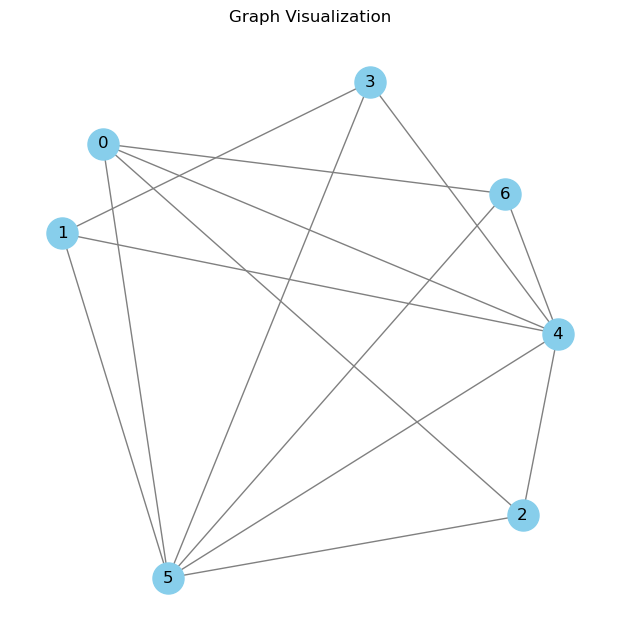

In [3]:
import networkx as nx
import numpy as np

G = nx.Graph()

for (patch_i, patch_j), edge_pairs in adj_graph_2d.items():
    if len(edge_pairs) == 0:
        continue

    total_length = 0.0
    for (pi0, pi1), _ in edge_pairs:
        pi0 = np.array(pi0)
        pi1 = np.array(pi1)
        edge_len = np.linalg.norm(pi1 - pi0)
        total_length += edge_len

    weight = -total_length
    G.add_edge(patch_i, patch_j, weight=weight)


print(f"[INFO] Built graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


pos = nx.spring_layout(G, seed=42) 

plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=12)
plt.title("Graph Visualization")
plt.axis('off')
plt.show()

In [4]:
# [4.1] Local curvature proxy for a polyline vertex (1 - |cos(theta)|).
# Used to pick a "sharpest" candidate edge in greedy edge-pair initialization.

def edge_curvature(p_prev, p_curr, p_next):
    v1 = p_curr - p_prev
    v2 = p_next - p_curr
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 < 1e-8 or norm2 < 1e-8:
        return -np.inf 
    cos_angle = np.dot(v1, v2) / (norm1 * norm2)
    return 1 - abs(cos_angle)  

# [4.1] Find the index of the maximum-curvature vertex along an edge polyline sequence.
# Returns (best_idx, max_curv) for later candidate selection.

def max_curvature_index(edge_seq):
    points = [np.array(e[0]) for e in edge_seq] + [np.array(edge_seq[-1][1])]
    max_curv = -np.inf
    best_idx = -1
    for i in range(1, len(points) - 1):
        curv = edge_curvature(points[i-1], points[i], points[i+1])
        if curv > max_curv:
            max_curv = curv
            best_idx = i - 1
    return best_idx, max_curv


# [4.1] 2D rotation matrix used by rigid placement in the packed layout.

def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

# [4.1] Compute rigid transform (R,t) that aligns segment (pj0->pj1) onto (pi0->pi1).
# Note: edge direction matters (reversing endpoints flips the transform).

def align_edge(edge_from, edge_to):
    v1 = edge_from[1] - edge_from[0]
    v2 = edge_to[1] - edge_to[0]
    angle1 = np.arctan2(v1[1], v1[0])
    angle2 = np.arctan2(v2[1], v2[0])
    theta = angle1 - angle2
    R = rotation_matrix(theta)
    t = edge_from[0] - R @ edge_to[0]
    return R, t

# [4.1] Apply a 2D rigid transform to a list/array of points.

def apply_transform(points, R, t):
    return (R @ points.T).T + t

# [4.1] Quick mismatch score for one candidate edge-pair (average crossed endpoint distance).
# Smaller means two segments arpe more consistent as a stitching correspondence.

def compute_edge_pair_distance(pair):
    (pi0, pi1), (pj0, pj1) = pair
    return (np.linalg.norm(np.array(pi0) - np.array(pj1)) +
            np.linalg.norm(np.array(pi1) - np.array(pj0))) / 2.0




# [4.1] Greedy initialization for edge-pair selection on a fixed topology.
# Input: mst edges + adj_graph_2d (multiple candidate edge pairs per neighbor pair)
# Output: best_choice[(u,v)] = chosen edge-pair index used by layout construction


def initialize_edge_pair_choice_greedy(mst, adj_graph_2d):
    edge_pair_choice = {}
    for u, v in mst.edges():
        key = (u, v) if (u, v) in adj_graph_2d else ((v, u) if (v, u) in adj_graph_2d else None)
        if key is None:
            print(f"[INIT][SKIP] edge {(u,v)} not in adj_graph_2d")
            continue

        pairs = adj_graph_2d.get(key, [])
        if not pairs:
            print(f"[INIT][SKIP] edge {key} has no candidate pairs")
            continue

        if len(pairs) == 1:
            edge_pair_choice[key] = 0
            print(f"[INIT] edge {key} -> choose idx=0 (only 1 candidate)")
            continue

        patch_a_edges = [pair[0] for pair in pairs]
        patch_b_edges = [pair[1] for pair in pairs]

        idx_a, curv_a = max_curvature_index(patch_a_edges)
        idx_b, curv_b = max_curvature_index(patch_b_edges)

        best_idx = idx_a if curv_a >= curv_b else idx_b
        edge_pair_choice[key] = best_idx
        print(f"[INIT] edge {key} -> choose idx={best_idx} (curv_a={curv_a}, curv_b={curv_b})")

    return edge_pair_choice



# [4.1] Construct a connected packed layout by rigidly placing patches.
# Input: best_choice (edge-pair index per adjacency) + patch geometry
# Output: layout[pid] = {'R': 2x2 rotation, 't': 2d translation} in packed 2D space


def construct_layout_from_choices(mst, adj_graph_2d, edge_pair_choice):

    layout = {}
    root = max(dict(mst.degree()).items(), key=lambda x: x[1])[0]
    layout[root] = {'R': np.eye(2), 't': np.zeros(2)}
    queue = deque([root])

    def get_candidates_order(curr, neighbor):

        if (curr, neighbor) in adj_graph_2d:
            key = (curr, neighbor); reverse = False
        elif (neighbor, curr) in adj_graph_2d:
            key = (neighbor, curr); reverse = True
        else:
            return None, None, []

        pairs = adj_graph_2d[key]
        if not pairs:
            return key, reverse, []

        preferred = edge_pair_choice.get(key, edge_pair_choice.get((key[1], key[0]), None))
        all_idxs = list(range(len(pairs)))

        if preferred is not None and preferred in all_idxs:
            all_idxs.remove(preferred)
            cand_order = [preferred] + all_idxs
        else:
            cand_order = all_idxs

        return key, reverse, cand_order

    while queue:
        curr = queue.popleft()
        R_curr = layout[curr]['R']
        t_curr = layout[curr]['t']

        for neighbor in mst.neighbors(curr):
            if neighbor in layout:
                continue

            key, reverse, cand_order = get_candidates_order(curr, neighbor)
            if key is None:
                print(f"[CONSTRUCT][SKIP] {curr}->{neighbor}: not in adj_graph_2d")
                continue
            if not cand_order:
                print(f"[CONSTRUCT][SKIP] {curr}->{neighbor}: no candidates")
                continue

            pairs = adj_graph_2d[key]
            placed = False
            last_err = None

            for pair_idx in cand_order:
                if pair_idx >= len(pairs):
                    print(f"[CONSTRUCT][WARN] {curr}->{neighbor} idx {pair_idx} out of range")
                    continue

                edge_from, edge_to = pairs[pair_idx]
                if reverse:
                    edge_from, edge_to = edge_to[::-1], edge_from[::-1]

                edge_from_global = apply_transform(np.array(edge_from), R_curr, t_curr)

                try:
                    R, t = align_edge(edge_from_global, np.array(edge_to))
                    layout[neighbor] = {'R': R, 't': t}
                    queue.append(neighbor)
                    placed = True
                    break
                except Exception as e:
                    last_err = e
                    print(f"[CONSTRUCT][FAIL] {curr}->{neighbor} key={key} idx={pair_idx} reverse={reverse} -> {e}")
                    continue

            if not placed:
                print(f"[CONSTRUCT][GIVEUP] {curr}->{neighbor} (all candidates failed). Last err: {last_err}")

    return layout




# [4.1] Export the packed layout as an OBJ for inspection / downstream processing.
# Uses layout transforms to move each patch into the packed 2D coordinates.


def save_layout_obj(layout, patches, patch_faces, filename="layout_init.obj"):

    all_vertices = []
    all_faces = []
    v_offset = 0
    for i in sorted(layout.keys()):
        R, t = layout[i]['R'], layout[i]['t']
        verts = apply_transform(patches[i], R, t)
        faces = patch_faces[i]
        all_vertices.extend(verts.tolist())
        all_faces.extend((faces + v_offset).tolist())
        v_offset += verts.shape[0]

    with open(filename, 'w') as f:
        for v in all_vertices:
            f.write(f"v {v[0]:.6f} {v[1]:.6f} 0.000000\n")
        for face in all_faces:
            f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")
            
def perturb_edge_pair_choice(edge_pair_choice, adj_graph_2d, num_changes=8):
    new_choice = edge_pair_choice.copy()
    keys = list(new_choice.keys())
    for _ in range(num_changes):
        key = random.choice(keys)
        candidates = adj_graph_2d.get(key, []) or adj_graph_2d.get((key[1], key[0]), [])
        if len(candidates) > 1:
            new_idx = random.randint(0, len(candidates) - 1)
            if new_idx != new_choice[key]:
                new_choice[key] = new_idx
    return new_choice


overlap_counter = defaultdict(int)

def optimize_layout_lns_sa(
    contours_raw, mst, adj_graph_2d, init_choice,
    T_start=1.0, T_end=1e-3, cooling_rate=0.98, max_iters=300
):
    best_choice = copy.deepcopy(init_choice)
    best_layout = construct_layout_from_choices(mst, adj_graph_2d, best_choice)
    best_score, best_pairs = evaluate_layout(best_layout, contours_raw)

    curr_choice = copy.deepcopy(best_choice)
    curr_score = best_score
    T = float(T_start)

    print(f"[Init] Initial score = {best_score}")

    for it in range(max_iters):
        new_choice = perturb_edge_pair_choice(curr_choice, adj_graph_2d, num_changes=7)

        new_layout = construct_layout_from_choices(mst, adj_graph_2d, new_choice)
        new_score, _ = evaluate_layout(new_layout, contours_raw)

        delta = new_score - curr_score
        accept = (delta < 0) or (np.random.rand() < np.exp(-delta / max(T, 1e-12)))

        if accept:
            curr_choice = copy.deepcopy(new_choice) 
            curr_score = new_score

            if new_score < best_score:
                best_score = new_score
                best_choice = copy.deepcopy(new_choice)  
                best_layout = copy.deepcopy(new_layout) 

        if it % 20 == 0:
            print(f"[{it:04d}] Score: {best_score}")

        T *= cooling_rate
        if T < T_end or best_score < 1e-10:
            break

    best_layout = construct_layout_from_choices(mst, adj_graph_2d, best_choice)

    _, overlap_pairs = evaluate_layout(best_layout, contours_raw)
    print(f"Final score：{best_score}，Overlap pairs: {overlap_pairs}")
    for pair in overlap_pairs:
        key = tuple(sorted(pair))
        overlap_counter[key] += 1

    return best_layout, best_choice

# [4.1] Compute overlap between placed patch contours under current layout (packed 2D).
# Used by evaluate_layout() as a penalty / hard constraint indicator.

def compute_overlap_area(layout, contours_raw):
    patch_polygons = {}
    for i in layout:
        R = layout[i]['R']
        t = layout[i]['t']
        contour = np.array(contours_raw[i]) 
        transformed = (R @ contour.T).T + t
        try:
            poly = Polygon(transformed)
            if not poly.is_valid:
                raise ValueError("poly is invalid")
            if poly.is_valid and poly.area > 0:
                patch_polygons[i] = poly
        except Exception as e:
            print(f"[Fail] patch {i}: {e}")
            continue

    total_overlap = 0
    overlap_pairs = []

    for i, j in combinations(patch_polygons.keys(), 2):
        poly_i = patch_polygons[i]
        poly_j = patch_polygons[j]
        if poly_i.intersects(poly_j):
            try:
                inter = poly_i.intersection(poly_j)
                if inter.area > 1e-10:
                    total_overlap += inter.area
                    overlap_pairs.append(tuple(sorted((i, j))))
            except:
                continue
    
    return total_overlap, overlap_pairs



# [4.1] Layout objective for SA/LNS.
# Returns (score, overlaps) combining overlap + bbox + matching terms (weights controlled by w_*).

def evaluate_layout(layout, contours_raw, adj_graph_2d=None, edge_pair_choice=None,
                    w_overlap=1000.0, w_bbox=0, w_match=0):
    overlap, overlap_pairs = compute_overlap_area(layout, contours_raw)
#     bbox = compute_bounding_box_area(layout, contours_raw)
#     match_error = 0.0
#     if adj_graph_2d and edge_pair_choice:
#         match_error = compute_matching_error(layout, contours_raw, adj_graph_2d, edge_pair_choice, curvature_threshold=0.2)

    return w_overlap * overlap, overlap_pairs #+ w_bbox * bbox + w_match * match_error


# [4.1] Extract one outer boundary loop from a triangulated patch (2D vertices + faces).
# Used to build contours_raw for overlap checking / visualization.

def extract_single_contour_from_faces(patches, patch_faces):

    contours = {}

    for pid, F in patch_faces.items():
        V = np.asarray(patches[pid], float)
        F = np.asarray(F, int)
        if V.size == 0 or F.size == 0:
            continue

        edge_count = Counter()
        for a, b, c in F:
            for u, v in ((a, b), (b, c), (c, a)):
                if u > v: u, v = v, u
                edge_count[(u, v)] += 1


        boundary_edges = [e for e, cnt in edge_count.items() if cnt == 1]
        if not boundary_edges:
            continue

        adj = defaultdict(list)
        for u, v in boundary_edges:
            adj[u].append(v)
            adj[v].append(u)

        used_edge = set()
        loops = []

        def walk(start):
            path = [start]
            cur = start
            prev = -1
            while True:
                nxt = None
                for n in adj[cur]:
                    e = (min(cur, n), max(cur, n))
                    if e in used_edge: 
                        continue
                    if n == prev and len(adj[cur]) > 1:
                        continue
                    nxt = n
                    used_edge.add(e)
                    break
                if nxt is None:
                    break
                path.append(nxt)
                prev, cur = cur, nxt
                if len(path) > 2 and path[-1] == path[0]:
                    break
            return path

        visited_nodes = set()
        for u, v in boundary_edges:
            for s in (u, v):
                if s in visited_nodes:
                    continue
                visited_nodes.add(s)
                path = walk(s)
                if len(path) >= 2:
                    loops.append(path)

        if not loops:
            continue

        def path_score(idx_path):
            p = idx_path
            closed = (len(p) > 2 and p[0] == p[-1])
            L = 0.0
            for i in range(len(p) - 1):
                L += np.linalg.norm(V[p[i+1]] - V[p[i]])
            return (1 if closed else 0, L, len(p))

        loops.sort(key=path_score, reverse=True)
        best = loops[0]


        is_closed = (len(best) > 2 and best[0] == best[-1])


        coords = [V[i] for i in best]
        if not is_closed:
            pass
        else:
            if not np.allclose(coords[0], coords[-1]):
                coords.append(coords[0])

        contours[pid] = np.asarray(coords, float)

    return contours

In [5]:
patches = {i: patch_2d_mesh[i].vertices[:, :2] for i in patch_2d_mesh}
patch_faces = {i: patch_2d_mesh[i].faces for i in patch_2d_mesh}
contours_raw = extract_single_contour_from_faces(patches, patch_faces)

In [6]:
# [4.1] Pre-filter adjacency edges: test each (u,v) pair alone and mark collision edges.
# Later we remove collision edges to build a cleaner graph for spanning tree sampling.

overlap_pairs_p = []

for u, v in G.edges():
    print(f"test patch pair ({u}, {v})...")


    T = nx.Graph()
    T.add_edge(u, v)

    try:
        init_choice_p = initialize_edge_pair_choice_greedy(T, adj_graph_2d)

        best_layout_p, best_choice_p = optimize_layout_lns_sa(
            contours_raw, T, adj_graph_2d, init_choice_p,
            T_start=1.0, T_end=1e-10, cooling_rate=0.99, max_iters=3000
        )

        score_p, overlaps_p = evaluate_layout(
            best_layout_p, contours_raw, adj_graph_2d, best_choice_p,
            w_overlap=1000, w_bbox=0, w_match=0
        )

        if score_p < 1e-10:
            print(f"Collision free：({u}, {v})")
        else:
            print(f"Collision detected：({u}, {v}), {len(overlaps_p)}")
            overlap_pairs_p.append((u, v))

    except Exception as e:
        print(f"[Error] Reason: {e}")

for u, v in overlap_pairs_p:
    print(f"Collision pairs: {u} – {v}")


test patch pair (3, 4)...
[INIT] edge (3, 4) -> choose idx=10 (curv_a=0.12064862722187586, curv_b=0.19076326643183594)
[Init] Initial score = 0.0
[0000] Score: 0.0
Final score：0.0，Overlap pairs: []
Collision free：(3, 4)
test patch pair (3, 5)...
[INIT] edge (3, 5) -> choose idx=7 (curv_a=0.9900570365384592, curv_b=0.9804276136602039)
[Init] Initial score = 0.2090231527697053
[0000] Score: 0.0
Final score：0.0，Overlap pairs: []
Collision free：(3, 5)
test patch pair (3, 1)...
[INIT] edge (3, 1) -> choose idx=9 (curv_a=0.23313506232236603, curv_b=0.10535870406065662)
[Init] Initial score = 0.0
[0000] Score: 0.0
Final score：0.0，Overlap pairs: []
Collision free：(3, 1)
test patch pair (4, 5)...
[INIT] edge (4, 5) -> choose idx=3 (curv_a=0.9500706523174536, curv_b=0.9807061594572504)
[Init] Initial score = 0.0
[0000] Score: 0.0
Final score：0.0，Overlap pairs: []
Collision free：(4, 5)
test patch pair (4, 1)...
[INIT] edge (4, 1) -> choose idx=43 (curv_a=0.9799572531336522, curv_b=0.9818181649740

[1380] Score: 61.057262589303186
[1400] Score: 61.057262589303186
[1420] Score: 61.057262589303186
[1440] Score: 61.057262589303186
[1460] Score: 61.057262589303186
[1480] Score: 61.057262589303186
[1500] Score: 61.057262589303186
[1520] Score: 61.057262589303186
[1540] Score: 61.057262589303186
[1560] Score: 61.057262589303186
[1580] Score: 61.057262589303186
[1600] Score: 61.057262589303186
[1620] Score: 61.057262589303186
[1640] Score: 61.057262589303186
[1660] Score: 61.057262589303186
[1680] Score: 61.057262589303186
[1700] Score: 61.057262589303186
[1720] Score: 61.057262589303186
[1740] Score: 61.057262589303186
[1760] Score: 61.057262589303186
[1780] Score: 61.057262589303186
[1800] Score: 61.057262589303186
[1820] Score: 61.057262589303186
[1840] Score: 61.057262589303186
[1860] Score: 61.057262589303186
[1880] Score: 61.057262589303186
[1900] Score: 61.057262589303186
[1920] Score: 61.057262589303186
[1940] Score: 61.057262589303186
[1960] Score: 61.057262589303186
[1980] Sco

[(3, 4), (3, 5), (3, 1), (4, 5), (4, 1), (4, 6), (4, 0), (5, 0), (5, 6), (6, 0), (0, 2)]
[3, 4, 5, 1, 6, 0, 2]


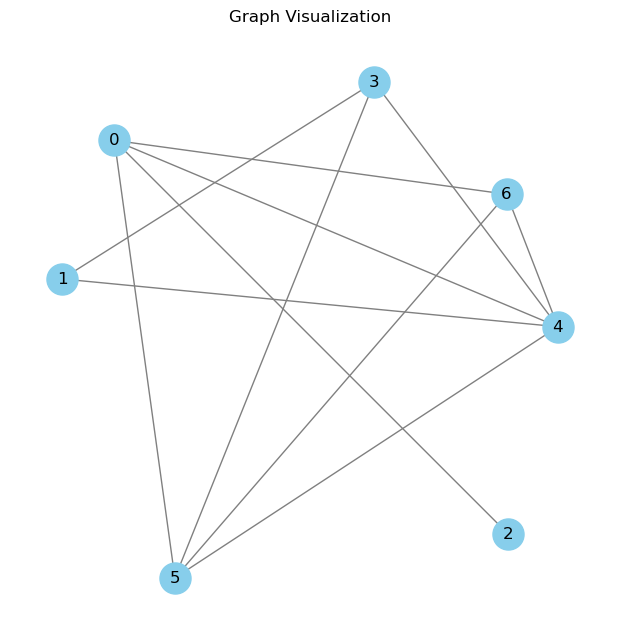

In [7]:
# [4.1] Remove collision edges from the adjacency graph before topology sampling.

G_clean = G.copy()
G_clean.remove_edges_from(overlap_pairs_p)
G=G_clean
print(G.edges())
print(G.nodes())

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=12)
plt.title("Graph Visualization")
plt.axis('off')
plt.show()

In [8]:
# [4.1] Sample candidate topologies (spanning trees) from the patch adjacency graph.
# Used to search a non-overlapping topology before geometry optimization.

def generate_random_spanning_trees(G, n=20, seed_base=2):

    trees = []
    seen_edge_sets = set()

    for i in range(n * 5): 
        seed = seed_base + i

        T_raw = nx.random_spanning_tree(G, seed=seed)
        
        if isinstance(T_raw, nx.Graph):
            T = T_raw
        elif isinstance(T_raw, dict):
            T = nx.Graph()
            for child, parent in T_raw.items():
                if child != parent:
                    T.add_edge(child, parent)
        else:
            T = nx.Graph()
            for i in range(len(T_raw)):
                if T_raw[i] != i:
                    T.add_edge(i, T_raw[i])

        edge_key = frozenset(tuple(sorted((u, v))) for u, v in T.edges())
        if edge_key not in seen_edge_sets:
            seen_edge_sets.add(edge_key)
            trees.append(T)
            if len(trees) == n:
                break

    return trees


random_trees = generate_random_spanning_trees(G, n=20)

for i, T in enumerate(random_trees):
    print(f"[Tree {i}] {T.number_of_nodes()} nodes, {T.number_of_edges()} edges")
    for u, v in T.edges():
        print(f"  {u} – {v}")


[Tree 0] 7 nodes, 6 edges
  4 – 6
  4 – 5
  4 – 1
  6 – 0
  5 – 3
  0 – 2
[Tree 1] 7 nodes, 6 edges
  3 – 4
  3 – 1
  4 – 6
  6 – 0
  0 – 2
  0 – 5
[Tree 2] 7 nodes, 6 edges
  3 – 1
  3 – 5
  4 – 6
  6 – 5
  6 – 0
  0 – 2
[Tree 3] 7 nodes, 6 edges
  3 – 4
  3 – 5
  4 – 1
  0 – 2
  0 – 5
  5 – 6
[Tree 4] 7 nodes, 6 edges
  3 – 1
  1 – 4
  4 – 6
  6 – 5
  6 – 0
  0 – 2
[Tree 5] 7 nodes, 6 edges
  3 – 1
  1 – 4
  4 – 5
  5 – 6
  0 – 2
  0 – 6
[Tree 6] 7 nodes, 6 edges
  3 – 1
  1 – 4
  4 – 6
  6 – 0
  0 – 2
  0 – 5
[Tree 7] 7 nodes, 6 edges
  4 – 0
  4 – 3
  0 – 2
  0 – 6
  3 – 1
  5 – 6
[Tree 8] 7 nodes, 6 edges
  3 – 1
  3 – 5
  4 – 5
  5 – 0
  5 – 6
  0 – 2
[Tree 9] 7 nodes, 6 edges
  3 – 1
  3 – 5
  4 – 6
  6 – 0
  0 – 2
  0 – 5
[Tree 10] 7 nodes, 6 edges
  3 – 4
  3 – 1
  4 – 6
  6 – 5
  0 – 2
  0 – 5
[Tree 11] 7 nodes, 6 edges
  3 – 4
  3 – 1
  4 – 6
  6 – 5
  6 – 0
  0 – 2
[Tree 12] 7 nodes, 6 edges
  3 – 4
  4 – 6
  4 – 1
  6 – 5
  6 – 0
  0 – 2
[Tree 13] 7 nodes, 6 edges
  4 – 0


In [9]:
# [4.1] Simulated annealing over spanning tree candidates / placements.
# Objective: compact layout with no overlap (packing score), keep patches connected.

best_score = float('inf')
best_layout = None
best_choice = None
best_mst_index = -1

all_pids = set(patches.keys()) 

for i, mst in enumerate(random_trees):

   
    tree_pids = set(mst.nodes())

    bad_edges = []
    for u, v in mst.edges():
        cands = adj_graph_2d.get((u, v)) or adj_graph_2d.get((v, u))
        if not cands:
            bad_edges.append((u, v))


   
    try:
        init_choice = initialize_edge_pair_choice_greedy(mst, adj_graph_2d)
        layout, choice = optimize_layout_lns_sa(
            contours_raw, mst, adj_graph_2d, init_choice,
            T_start=1.0, T_end=1e-10, cooling_rate=0.99, max_iters=4000
        )
    except Exception as e:
        print(f"Topo {i+1} failed: {e}")
        continue

    if layout is None:
        print(f"Topo {i+1} cannot construct layout")
        continue

    layout_pids = set(layout.keys())
    if layout_pids != all_pids:
        missing_after = sorted(all_pids - layout_pids)
        print(f"Topo {i+1} lacks nodes: {missing_after}")
        score = 1e12
    else:
        score, _ = evaluate_layout(layout, contours_raw)


    if score < 1e-10:
        print(f"\n Topo {i} score = 0")
        best_score = score
        best_layout = layout
        best_choice = choice
        best_mst_index = i
        break

    if score < best_score:
        best_score = score
        best_layout = layout
        best_choice = choice
        best_mst_index = i

if best_layout is not None:
    print(f"\n best layout = {best_mst_index}, score = {best_score}")
    save_layout_obj(best_layout, patches, patch_faces, filename=f"layout_final_mst{best_mst_index}.obj")
else:
    print("All topos failed!!!!!!!!!")


if len(overlap_counter) == 0:
    print("no overlap pair")
else:
    sorted_overlap = sorted(overlap_counter.items(), key=lambda x: -x[1])
    for (i, j), count in sorted_overlap:
        print(f"Patch ({i}, {j}) : {count} times")


[INIT] edge (4, 6) -> choose idx=9 (curv_a=0.13959625299113865, curv_b=0.36277898095795125)
[INIT] edge (4, 5) -> choose idx=3 (curv_a=0.9500706523174536, curv_b=0.9807061594572504)
[INIT] edge (4, 1) -> choose idx=43 (curv_a=0.9799572531336522, curv_b=0.9818181649740181)
[INIT] edge (6, 0) -> choose idx=30 (curv_a=0.2427676113996302, curv_b=0.18475774218133412)
[INIT] edge (5, 3) -> choose idx=60 (curv_a=0.9910490434014753, curv_b=0.943489074773746)
[INIT] edge (0, 2) -> choose idx=46 (curv_a=0.9836638163231746, curv_b=0.9752344666144074)
[Init] Initial score = 57.36587506864455
[0000] Score: 57.36587506864455
[0020] Score: 0.5275857283134109
[0040] Score: 0.0021896361491664435
[0060] Score: 1.9982739507053753e-07
[0080] Score: 1.9982739507053753e-07
[0100] Score: 1.9982739507053753e-07
[0120] Score: 1.9982739507053753e-07
[0140] Score: 1.9982739507053753e-07
[0160] Score: 1.9982739507053753e-07
[0180] Score: 1.9982739507053753e-07
[0200] Score: 1.9982739507053753e-07
[0220] Score: 1.

In [10]:
# =============================================================================
# 4.2 Generating Point Sets on the Patch Boundary
# - Extract boundary polylines in the packed 2D layout
# - Select high-curvature candidates (turning angle / discrete curvature)
# - Enforce max spacing by inserting midpoints
# - Build correspondence_map (+ world-space versions) for later lacing
# =============================================================================

In [11]:
# [4.2] Point-in-patch test.
# Used to keep generated points / routing segments inside the patch boundary.

def is_inside_patch(pt, faces, verts):

    # Triangle membership test (barycentric) used by is_inside_patch().
    def point_in_triangle(p, a, b, c):
        v0 = c - a
        v1 = b - a
        v2 = p - a

        dot00 = np.dot(v0, v0)
        dot01 = np.dot(v0, v1)
        dot02 = np.dot(v0, v2)
        dot11 = np.dot(v1, v1)
        dot12 = np.dot(v1, v2)

        denom = dot00 * dot11 - dot01 * dot01
        if denom == 0:
            return False

        u = (dot11 * dot02 - dot01 * dot12) / denom
        v = (dot00 * dot12 - dot01 * dot02) / denom
        return (u >= 0) and (v >= 0) and (u + v <= 1)

    for face in faces:
        a, b, c = verts[face[0]], verts[face[1]], verts[face[2]]
        if point_in_triangle(pt, a, b, c):
            return True
    return False

# [4.2] Shift stitch points along local boundary direction to create in/out offset points.
# Used later to decide lacing direction and generate shifted_in_stitch_points.

def shift_stitch_points_along_edges(
    stitch_points_world, layout, patches, patch_faces, contours, shift_eps=0.5, dir_ward="inward"
):

    shifted_points = []

    polylines = contours

    for (pid, pt_world) in stitch_points_world:
        if pid not in layout or pid not in polylines:
            continue

        R, t = layout[pid]['R'], layout[pid]['t']
        R_inv = R.T
        verts = patches[pid]
        faces = patch_faces[pid]
        polyline = np.array(polylines[pid]) 

        pt_local = R_inv @ (np.array(pt_world) - t)

        dists = np.linalg.norm(polyline - pt_local, axis=1)
        idx = np.argmin(dists)
        N = len(polyline)

        a = polyline[(idx - 1) % N]
        b = pt_local
        c = polyline[(idx + 1) % N]

        v1 = b - a
        v2 = b - c
        v1_valid = np.linalg.norm(v1) >= 1e-6
        v2_valid = np.linalg.norm(v2) >= 1e-6

        if v1_valid and v2_valid:
            dir_vec = v1 / np.linalg.norm(v1) + v2 / np.linalg.norm(v2)
        elif v1_valid or v2_valid:
            dir_vec = v1 / np.linalg.norm(v1) if v1_valid else v2 / np.linalg.norm(v2)
        else:
            continue

        if np.linalg.norm(dir_vec) < 1e-6:
            continue
        dir_unit = dir_vec / np.linalg.norm(dir_vec)

        if (dir_ward == "inward"):
            pt_shift_local = pt_local + shift_eps * dir_unit
            if not is_inside_patch(pt_shift_local, faces, verts):
                pt_shift_local = pt_local - shift_eps * dir_unit
#                 if not is_inside_patch(pt_shift_local, faces, verts):
#                     continue
        elif (dir_ward == "outward"):
            pt_shift_local = pt_local + shift_eps * dir_unit
            if is_inside_patch(pt_shift_local, faces, verts):
                pt_shift_local = pt_local - shift_eps * dir_unit
#                 if is_inside_patch(pt_shift_local, faces, verts):
#                     continue

        pt_shift_world = R @ pt_shift_local + t
        shifted_points.append((pid, pt_shift_world))

    return shifted_points

    
def visualize_layout_with_point_pairs(
    patches, patch_faces, layout, stitch_points, correspondence_map_world,
    adj_graph_2d, contours_raw=None, figsize=(10, 10)
):
    fig, ax = plt.subplots(figsize=figsize)
    patch_polys = []
    pair_number_to_points = {}

    # Draw patches
    for pid, verts in patches.items():
        if pid not in layout:
            continue
        R, t = layout[pid]['R'], layout[pid]['t']
        transformed = (R @ verts.T).T + t
        for face in patch_faces[pid]:
            poly_pts = [transformed[i] for i in face]
            patch_polys.append(mPolygon(poly_pts, closed=True))
    patch_collection = PatchCollection(
        patch_polys, facecolor='lightgray', edgecolor='black', linewidth=1, alpha=0.6
    )
    ax.add_collection(patch_collection)

    ptworld2pttuple = dict()

    for pid in patches:
        if pid not in layout:
            continue

        # Priority: use contours_raw
        if contours_raw is not None and pid in contours_raw:
            poly_data = contours_raw[pid]
            # Compatible with both list[np.ndarray] and ndarray
            if isinstance(poly_data, list):
                polylines = poly_data
            else:
                polylines = [poly_data]

            for poly in polylines:
                if poly is None or len(poly) == 0:
                    continue
                R, t = layout[pid]['R'], layout[pid]['t']
                for pt in poly:
                    pt_world = R @ np.array(pt) + t
                    ptworld2pttuple[(pid, tuple(pt_world))] = tuple(pt)

        else:
            raw_edges = []
            for (i, j), edge_pair_list in adj_graph_2d.items():
                if i == pid:
                    for edge_i, _ in edge_pair_list:
                        raw_edges.append((np.array(edge_i[0]), np.array(edge_i[1])))
                elif j == pid:
                    for _, edge_j in edge_pair_list:
                        raw_edges.append((np.array(edge_j[0]), np.array(edge_j[1])))
            if len(raw_edges) < 1:
                continue
            poly = sort_polyline(raw_edges)
            R, t = layout[pid]['R'], layout[pid]['t']
            for pt in poly:
                pt_world = R @ pt + t
                ptworld2pttuple[(pid, tuple(pt_world))] = tuple(pt)

    stitch_idx_map = {
        (pid, tuple(pt_world)): idx for idx, (pid, pt_world) in enumerate(stitch_points)
    }

    used = set()
    pair_id = 1
    for idx, (pid, pt_world) in enumerate(stitch_points):
        if pid not in layout:
            continue
        key = (pid, tuple(pt_world))
        if key in used:
            continue
            
        # Find all corresponding points in world coordinates
        group = [key]
        if key in correspondence_map_world:
            for corr_key in correspondence_map_world[key]:
                if corr_key in stitch_idx_map and corr_key not in group:
                    group.append(corr_key)
        
        # Visualize the group
        current_group_points = []
        for k in group:
            if k in used:
                continue
            idx2 = stitch_idx_map[k]
            px, py = stitch_points[idx2][1][0], stitch_points[idx2][1][1]
            ax.scatter(px, py, color='red', s=24)
            ax.text(px, py, str(pair_id), color='blue', fontsize=14, fontweight='bold')
            used.add(k)
            current_group_points.append((k, (px, py)))

        pair_number_to_points[pair_id] = current_group_points
        pair_id += 1

    ax.set_aspect('equal')
    ax.set_title("2D Layout: Curvature Correspondence Numbered")
    plt.axis('off')
    plt.show()
    
    return pair_number_to_points





def visualize_layout_with_points(
    patches,
    patch_faces,
    layout,
    stitch_points=None,
    merged_contour=None,   
    figsize=(10, 10),
    outline_color='black',
    outline_lw=1.2,
    merged_color='tab:blue',
    merged_lw=2.0,
    stitch_color='red',
    stitch_size=20,
    title="2D Packed Layout (Outlines Only)"
):


    fig, ax = plt.subplots(figsize=figsize)

    all_outline_segs = []  

    if merged_contour is not None and len(merged_contour) >= 2:
        path_xy = np.array([pt for _, pt in merged_contour], float)
        ax.plot(path_xy[:, 0], path_xy[:, 1], linewidth=merged_lw, label='Merged Contour', color=merged_color)


    if stitch_points:
        stitch_points_np = np.array([pt for _, pt in stitch_points], float)
        ax.scatter(stitch_points_np[:, 0], stitch_points_np[:, 1], s=stitch_size, color=stitch_color, label='Stitch Points')


    ax.set_aspect('equal')
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    if labels:
        ax.legend()
    ax.axis('off')
    plt.show()

def export_svg_contour_and_stitches(
    merged_contour,                
    stitch_points=None,           
    svg_filename='layout.svg',
    target_width_mm=410.0,
    target_height_mm=200.0,
    padding_mm=5.0,
    contour_color="#000000",
    contour_stroke_mm=0.2,
    close_contour=False,   
    stitch_fill="#ff0000",
    stitch_radius_mm=0.5,
    add_border=True,
    border_color="blue",
    border_stroke_mm=0.01         
):
    all_pts = []
    if merged_contour:
        all_pts += [tuple(pt) for _, pt in merged_contour]
    if stitch_points:
        all_pts += [tuple(pt) for _, pt in stitch_points]

    if not all_pts:
        raise ValueError("没有可导出的点：merged_contour 和 stitch_points 都为空。")

    import numpy as np
    pts = np.array(all_pts, dtype=float)
    xmin, ymin = pts[:,0].min(), pts[:,1].min()
    xmax, ymax = pts[:,0].max(), pts[:,1].max()

    w = max(xmax - xmin, 1e-9)
    h = max(ymax - ymin, 1e-9)

    avail_w = max(target_width_mm - 2*padding_mm, 1e-6)
    avail_h = max(target_height_mm - 2*padding_mm, 1e-6)
    s = min(avail_w / w, avail_h / h)

    def world_to_mm(p):
        x, y = float(p[0]), float(p[1])
        X = padding_mm + (x - xmin) * s
        Y = padding_mm + (y - ymin) * s
        Y = target_height_mm - Y
        return X, Y

    contour_path = ""
    if merged_contour and len(merged_contour) >= 2:
        xy = [world_to_mm(pt) for _, pt in merged_contour]
        # M x0 y0 L x1 y1 ...
        path_cmds = [f"M {xy[0][0]:.6f} {xy[0][1]:.6f}"] + [
            f"L {x:.6f} {y:.6f}" for (x, y) in xy[1:]
        ]
        if close_contour:
            path_cmds.append("Z")
        contour_path = " ".join(path_cmds)

    svg = []
    svg.append(
        f'<svg xmlns="http://www.w3.org/2000/svg" '
        f'width="{target_width_mm}mm" height="{target_height_mm}mm" '
        f'viewBox="0 0 {target_width_mm} {target_height_mm}">'
    )

    if add_border:
        svg.append(
            f'<rect x="0" y="0" width="{target_width_mm}" height="{target_height_mm}" '
            f'fill="none" stroke="{border_color}" stroke-width="{border_stroke_mm}mm" />'
        )

    if contour_path:
        svg.append(
            f'<path d="{contour_path}" '
            f'stroke="{contour_color}" stroke-width="{contour_stroke_mm}mm" '
            f'fill="none" stroke-linecap="round" stroke-linejoin="round"/>'
        )

    if stitch_points:
        for _, pt in stitch_points:
            cx, cy = world_to_mm(pt)
            svg.append(
                f'<circle cx="{cx:.6f}" cy="{cy:.6f}" r="{stitch_radius_mm}mm" '
                f'fill="{stitch_fill}" />'
            )

    svg.append('</svg>')

    with open(svg_filename, 'w', encoding='utf-8') as f:
        f.write("\n".join(svg))

    return svg_filename


def export_layout_with_stitch_points_to_dxf(layout, outlines, stitch_points, filename='layout_with_stitch.dxf', scale=1.0):
    doc = ezdxf.new(dxfversion='R2010')
    msp = doc.modelspace()

    for pid, polyline_list in outlines.items():
        if pid not in layout:
            continue
        R, t = layout[pid]['R'], layout[pid]['t']
        for polyline in polyline_list:
            polyline_np = np.array(polyline)
            transformed = (R @ polyline_np.T).T + t
            transformed *= scale
            pts = [tuple(p) for p in transformed]
            is_closed = np.linalg.norm(transformed[0] - transformed[-1]) < 1e-6
            msp.add_lwpolyline(pts, close=is_closed, dxfattribs={'color': 1})

    for _, pt in stitch_points:
        msp.add_circle(center=(pt[0] * scale, pt[1] * scale), radius=0.5, dxfattribs={'color': 1})

    doc.saveas(filename)

# [4.2] Debug export: draw stitch points and local direction vectors (for visual checking).

def export_layout_with_stitch_vectors_to_svg(
    layout,
    shifted_points,
    outlines_for_direction,
    outlines_for_drawing,
    stitch_points_raw,
    patches,
    patch_faces,
    target_width_mm=100.0,
    target_height_mm=130.0,
    padding_mm=0.0,
    svg_filename: Optional[str] = 'layout.svg',
    pdf_filename: Optional[str] = 'layout.pdf',
    contour_stroke_width: Optional[str] = '0.1mm',
    vector_stroke_width: Optional[str] = '0.1mm',
    cross_stroke_width: Optional[str] = '0.1mm',
    red_point_radius: Optional[str] = '0.5mm',
    stitch_hole_radius: Optional[str] = '0.5mm',
    border: Optional[str] = '0.5mm'
):
    stitch_points = [pt for _, pt in stitch_points_raw]
    shifted_pts = [pt for _, pt in shifted_points]
    all_pts = []

    for pid, polyline_list in outlines_for_drawing.items():
        if pid not in layout:
            continue
        R, t = layout[pid]['R'], layout[pid]['t']
        for polyline in polyline_list:
            polyline_np = np.array(polyline)
            transformed = (R @ polyline_np.T).T + t
            all_pts.extend(transformed.tolist())

    all_pts.extend(stitch_points)

    all_pts_np = np.array(all_pts)
    min_x, min_y = np.min(all_pts_np, axis=0)
    max_x, max_y = np.max(all_pts_np, axis=0)
    width, height = max_x - min_x, max_y - min_y

    drawable_width = target_width_mm - 2 * padding_mm
    drawable_height = target_height_mm - 2 * padding_mm
    scale = min(drawable_width / width, drawable_height / height)

    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    view_min_x = center_x - drawable_width / scale / 2
    view_min_y = center_y - drawable_height / scale / 2
    shift_x = -view_min_x * scale + padding_mm
    shift_y = -view_min_y * scale + padding_mm

    if svg_filename is not None or pdf_filename is not None:
        doc = Document()
        svg = doc.createElement('svg')
        svg.setAttribute('xmlns', 'http://www.w3.org/2000/svg')
        svg.setAttribute('version', '1.1')
        svg.setAttribute('width', f'{target_width_mm:.2f}mm')
        svg.setAttribute('height', f'{target_height_mm:.2f}mm')
        svg.setAttribute('viewBox', f'0 0 {target_width_mm:.2f} {target_height_mm:.2f}')
        doc.appendChild(svg)

        if contour_stroke_width:
            for pid, polyline_list in outlines_for_drawing.items():
                if pid not in layout:
                    continue
                R, t = layout[pid]['R'], layout[pid]['t']
                for polyline in polyline_list:
                    polyline_np = np.array(polyline)
                    transformed = (R @ polyline_np.T).T + t
                    pts = transformed.tolist()
                    is_closed = np.linalg.norm(transformed[0] - transformed[-1]) < 1e-6
                    point_str = " ".join([
                        f"{p[0] * scale + shift_x:.4f},{p[1] * scale + shift_y:.4f}"
                        for p in pts
                    ])
                    poly = doc.createElement('polyline')
                    poly.setAttribute('points', point_str)
                    poly.setAttribute('fill', 'none')
                    poly.setAttribute('stroke', 'red')
                    poly.setAttribute('stroke-width', contour_stroke_width)
                    if is_closed:
                        poly.setAttribute('stroke-linejoin', 'round')
                    svg.appendChild(poly)

        if vector_stroke_width:
            for stitch_pt, shifted_pt in zip(stitch_points, shifted_pts):
                x1 = stitch_pt[0] * scale + shift_x
                y1 = stitch_pt[1] * scale + shift_y
                x2 = shifted_pt[0] * scale + shift_x
                y2 = shifted_pt[1] * scale + shift_y
                line = doc.createElement('line')
                line.setAttribute('x1', f'{x1:.4f}')
                line.setAttribute('y1', f'{y1:.4f}')
                line.setAttribute('x2', f'{x2:.4f}')
                line.setAttribute('y2', f'{y2:.4f}')
                line.setAttribute('stroke', 'red')
                line.setAttribute('stroke-width', vector_stroke_width)
                svg.appendChild(line)

        if cross_stroke_width:
            cross_len = max(width, height) * scale * 2
            cx = center_x * scale + shift_x
            cy = center_y * scale + shift_y
            line_h = doc.createElement('line')
            line_h.setAttribute('x1', f'{cx - cross_len:.4f}')
            line_h.setAttribute('y1', f'{cy:.4f}')
            line_h.setAttribute('x2', f'{cx + cross_len:.4f}')
            line_h.setAttribute('y2', f'{cy:.4f}')
            line_h.setAttribute('stroke', 'blue')
            line_h.setAttribute('stroke-width', cross_stroke_width)
            svg.appendChild(line_h)

            line_v = doc.createElement('line')
            line_v.setAttribute('x1', f'{cx:.4f}')
            line_v.setAttribute('y1', f'{cy - cross_len:.4f}')
            line_v.setAttribute('x2', f'{cx:.4f}')
            line_v.setAttribute('y2', f'{cy + cross_len:.4f}')
            line_v.setAttribute('stroke', 'blue')
            line_v.setAttribute('stroke-width', cross_stroke_width)
            svg.appendChild(line_v)

        if red_point_radius:
            for pt in stitch_points:
                cx = pt[0] * scale + shift_x
                cy = pt[1] * scale + shift_y
                circle = doc.createElement('circle')
                circle.setAttribute('cx', f'{cx:.4f}')
                circle.setAttribute('cy', f'{cy:.4f}')
                circle.setAttribute('r', red_point_radius)
                circle.setAttribute('fill', 'red')
                svg.appendChild(circle)
                

        if stitch_hole_radius:
            for pt in shifted_pts:
                cx = pt[0] * scale + shift_x
                cy = pt[1] * scale + shift_y
                circle = doc.createElement('circle')
                circle.setAttribute('cx', f'{cx:.4f}')
                circle.setAttribute('cy', f'{cy:.4f}')
                circle.setAttribute('r', stitch_hole_radius)                  
                circle.setAttribute('fill', 'none')          
                circle.setAttribute('stroke', 'red')            
                circle.setAttribute('stroke-width', '0.3')       
                svg.appendChild(circle)


        if border:
            border_rect = doc.createElement('rect')
            border_rect.setAttribute('x', '0')
            border_rect.setAttribute('y', '0')
            border_rect.setAttribute('width', f'{target_width_mm:.4f}')
            border_rect.setAttribute('height', f'{target_height_mm:.4f}')
            border_rect.setAttribute('fill', 'none')
            border_rect.setAttribute('stroke', 'blue')
            border_rect.setAttribute('stroke-width', border)
            svg.appendChild(border_rect)


        svg_content = doc.toprettyxml(indent='  ')

        if svg_filename is not None:
            with open(svg_filename, 'w', encoding='utf-8') as f:
                f.write(svg_content)

        if pdf_filename is not None:
            if svg_filename is None:
                import tempfile
                with tempfile.NamedTemporaryFile(delete=False, suffix='.svg', mode='w', encoding='utf-8') as tmp_svg:
                    tmp_svg.write(svg_content)
                    tmp_svg_path = tmp_svg.name
            else:
                tmp_svg_path = svg_filename
            drawing = svg2rlg(tmp_svg_path)
            renderPDF.drawToFile(drawing, pdf_filename)

    return svg_filename, pdf_filename


def turning_angle(p_prev, p_curr, p_next, degrees=True):
    v1 = p_curr - p_prev
    v2 = p_next - p_curr
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 < 1e-8 or norm2 < 1e-8:
        return 0.0
    cos_theta = np.dot(v1, v2) / (norm1 * norm2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle) if degrees else angle



def sliding_headtail_angle(polyline, window_edges=1, degrees=True):

    N = len(polyline)
    result = np.full(N, np.nan)
    for i in range(window_edges, N - window_edges):
        p_start = polyline[i - window_edges]
        p_mid   = polyline[i]
        p_end   = polyline[i + window_edges]
        angle = turning_angle(p_start, p_mid, p_end, degrees=degrees)
        result[i] = angle
    return result


def compute_discrete_curvature(polyline, offset=2):

    N = len(polyline)
    curvature = np.full(N, np.nan)
    for i in range(offset, N - offset):
        p_prev = polyline[i - offset]
        p_curr = polyline[i]
        p_next = polyline[i + offset]

        v1 = p_prev - p_curr
        v2 = p_next - p_curr
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        if norm1 < 1e-8 or norm2 < 1e-8:
            continue

        cos_theta = np.dot(v1, v2) / (norm1 * norm2)
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))

        chord_len = np.linalg.norm(p_next - p_prev)
        if chord_len > 1e-8:
            curvature[i] = 2 * np.sin(angle) / chord_len
    return curvature

def smooth_curvature(curvatures, window=3):
    from scipy.ndimage import uniform_filter1d
    return uniform_filter1d(curvatures, size=window, mode='nearest')




# [4.2] Collect high-curvature boundary points as merging point candidates.
# Output: stitch_points (+ correspondence_map) used by lacing area tracing in [4.3].

def collect_high_curvature_points(contours, layout, patches, adj_graph_2d,
                                  angle_min_deg=50.0, angle_max_deg=90.0, distance_threshold=None):
    
    all_curv_values = []
    patch_curvatures = {} 

    for pid, poly in contours.items():
        if len(poly) < 3:
            continue
        curvatures = compute_discrete_curvature(poly, offset=3)
        patch_curvatures[pid] = curvatures
        all_curv_values.extend([c for c in curvatures if not np.isnan(c)])

    # Diagnostic plot for tuning curvature thresholds; can be disabled for batch runs.
    plt.hist(all_curv_values, bins=100)
    plt.title("Curvature Distribution")
    plt.xlabel("Curvature")
    plt.ylabel("Frequency")
    plt.show()

    curv_min = np.percentile(all_curv_values, 90)
    curv_max = np.inf

    all_candidates = {}

    for pid, poly in contours.items():
        if len(poly) < 3:
            continue

        curvatures = patch_curvatures[pid]

        for k in range(len(poly)):
            curv = curvatures[k]
            if np.isnan(curv):
                continue
            if curv_min <= curv <= curv_max:
                pt_tuple = tuple(poly[k])
                all_candidates[(pid, pt_tuple)] = (curv, k)



    all_points = set()
    for (i, j), edge_pair_list in adj_graph_2d.items():
        for (edge_i, edge_j) in edge_pair_list:
            for k in range(2):
                all_points.add((i, tuple(edge_i[k])))
                all_points.add((j, tuple(edge_j[k])))

    class UnionFind:
        def __init__(self):
            self.parent = dict()
        def find(self, x):
            if x not in self.parent:
                self.parent[x] = x
            if self.parent[x] != x:
                self.parent[x] = self.find(self.parent[x])
            return self.parent[x]
        def union(self, x, y):
            self.parent[self.find(x)] = self.find(y)

    uf = UnionFind()
    for (i, j), edge_pair_list in adj_graph_2d.items():
        for (edge_i, edge_j) in edge_pair_list:
            for k in range(2):
                pi, pj = tuple(edge_i[k]), tuple(edge_j[k])
                uf.union((i, pi), (j, pj))

    correspondence_map = defaultdict(set)
    for key in all_points:
        root = uf.find(key)
        for other in all_points:
            if other != key and uf.find(other) == root:
                correspondence_map[key].add(other)

    extended_candidates = dict(all_candidates)
    for key in list(all_candidates.keys()):
        for corr in correspondence_map.get(key, set()):
            if corr not in extended_candidates:
                extended_candidates[corr] = (all_candidates[key][0], None)

    final_points = set()
    used = set()
    disabled = set()
    

    MAX_GAP = 3

    for pid, poly in sorted(contours.items()):
        k = 0
        while k < len(poly):
            group = []
            temp_k = k
            gaps_left = MAX_GAP
            saw_candidate = False

            while temp_k < len(poly):
                key = (pid, tuple(poly[temp_k]))
                is_candidate = (key in extended_candidates) and (key not in used)

                if is_candidate:
                    group.append(key)   
                    saw_candidate = True
                    gaps_left = MAX_GAP 
                    temp_k += 1
                else:
                    if gaps_left > 0:
                        gaps_left -= 1 
                        temp_k += 1
                        continue
                    else:
                        break

            if not saw_candidate:
                k += 1
                continue

            multi_corr_points = []
            for gk in group:
                corrs = correspondence_map.get(gk, set())
                unique_corrs = set(corrs)
                if len(unique_corrs) >= 2:
                    multi_corr_points.append(gk)

            if multi_corr_points:
                group_to_keep = set()
                for mk in multi_corr_points:
                    group_to_keep.add(mk)
                    group_to_keep.update(correspondence_map.get(mk, set()))
                final_points.update(group_to_keep)

                corr_set = set(group)  
                used.update(corr_set)

                corr_set = set()     
                for gk in group:
                    corr_set.update(correspondence_map.get(gk, set()))
                disabled.update(corr_set)

                k = temp_k          
                continue
            else:
                corr_set = set(group)
                for gk in group:
                    corr_set.update(correspondence_map.get(gk, set()))
                corr_set -= disabled
                if not corr_set:
                    k = temp_k       
                    continue

                chosen_key = max(
                    corr_set,
                    key=lambda x: extended_candidates.get(x, (0,))[0]
                )
                group_to_keep = {chosen_key}
                group_to_keep.update(correspondence_map.get(chosen_key, set()))
                final_points.update(group_to_keep)
                used.update(corr_set)
                k = temp_k

 

    if distance_threshold is not None:
        final_points_set = set(final_points)
        filtered_final_points = set()
        processed_groups = set()


        initial_groups = []
        for key in final_points_set:
            if key in processed_groups:
                continue
            corrs = correspondence_map.get(key, set())
            corrs_group = corrs | {key}
            processed_groups.update(corrs_group)
            if len(corrs_group) >= 2:
                initial_groups.append(corrs_group)

        merged_groups = []
        processed_group_indices = set()

        for i, group in enumerate(initial_groups):
            if i in processed_group_indices:
                continue

            current_merge = set(group)
            queue = [i]
            processed_group_indices.add(i)

            while queue:
                group_idx = queue.pop()
                for pt in initial_groups[group_idx]:
                    pid_i, coord_i = pt
                    if pid_i not in layout:
                        continue

                    pt_i_world = layout[pid_i]['R'] @ np.array(coord_i) + layout[pid_i]['t']

                    for j, other_group in enumerate(initial_groups):
                        if j in processed_group_indices:
                            continue

                        should_merge = False
                        for other_pt in other_group:
                            pid_j, coord_j = other_pt
                            if pid_j not in layout:
                                continue

                            pt_j_world = layout[pid_j]['R'] @ np.array(coord_j) + layout[pid_j]['t']
                            if (np.linalg.norm(pt_i_world - pt_j_world) < distance_threshold) or \
                               (other_pt in correspondence_map.get(pt, set())) or \
                               (pt in correspondence_map.get(other_pt, set())):
                                should_merge = True
                                break

                        if should_merge:
                            current_merge.update(other_group)
                            queue.append(j)
                            processed_group_indices.add(j)
                            break

            if len(current_merge) >= 2:
                merged_groups.append(current_merge)
                for pt in current_merge:
                    correspondence_map[pt] = current_merge - {pt}

        for group in merged_groups:
            points_list = list(group)
            keep_points = set()

            for i in range(len(points_list)):
                pt_i = points_list[i]
                pid_i, coord_i = pt_i
                if pid_i not in layout:
                    continue

                pt_i_world = layout[pid_i]['R'] @ np.array(coord_i) + layout[pid_i]['t']
                keep = True

                for kept_pt in keep_points:
                    pid_k, coord_k = kept_pt
                    pt_k_world = layout[pid_k]['R'] @ np.array(coord_k) + layout[pid_k]['t']
                    if np.linalg.norm(pt_i_world - pt_k_world) < distance_threshold:
                        keep = False
                        break

                if keep:
                    keep_points.add(pt_i)

            if len(keep_points) >= 2:
                filtered_final_points.update(keep_points)

        final_points = list(filtered_final_points)

    stitch_points = []
    for pid, pt in final_points:
        if pid in layout:
            pt_world = layout[pid]['R'] @ np.array(pt) + layout[pid]['t']
            stitch_points.append((pid, tuple(pt_world)))


    final_points_set = set(final_points)
    correspondence_map_filtered = defaultdict(set)
    for key in final_points_set:
        if key in correspondence_map:
            filtered_targets = {
                target for target in correspondence_map[key]
                if target in final_points_set
            }
            if filtered_targets:
                correspondence_map_filtered[key] = filtered_targets
    correspondence_map_world = {}
    for (pid, pt_local), corr_list in correspondence_map_filtered.items():
        if pid not in layout:
            continue
        R, t = layout[pid]['R'], layout[pid]['t']
        pt_world = R @ np.array(pt_local) + t
        world_key = (pid, tuple(pt_world))

        world_corrs = []
        for corr_pid, corr_pt_local in corr_list:
            if corr_pid not in layout:
                continue
            R_corr, t_corr = layout[corr_pid]['R'], layout[corr_pid]['t']
            corr_pt_world = R_corr @ np.array(corr_pt_local) + t_corr
            world_corrs.append((corr_pid, tuple(corr_pt_world)))

        correspondence_map_world[world_key] = world_corrs
        
    visualize_layout_with_point_pairs(
        patches,          
        patch_faces,      
        layout,           
        stitch_points,       
        correspondence_map_world, 
        adj_graph_2d,   
        contours,
        figsize=(10, 10) 
    )
    return stitch_points, correspondence_map_world

In [12]:
def _K(p):
    a = np.asarray(p, float)
    return (float(a[0]), float(a[1]))

def edge_key(p0, p1):
    a, b = _K(p0), _K(p1)
    return (a, b) if a <= b else (b, a)

def segments_to_polylines(segments):

    if not segments:
        return []

    adj = defaultdict(list)
    undirected = set()
    for p0, p1 in segments:
        a, b = _K(p0), _K(p1)
        if a == b:
            continue
        key = (a, b) if a <= b else (b, a)
        if key in undirected:
            continue
        undirected.add(key)
        adj[a].append(b)
        adj[b].append(a)

    nodes = list(adj.keys())
    seen = set()
    polylines = []

    def trace_component(component_nodes):
        deg = {v: len(adj[v]) for v in component_nodes}
        endpoints = [v for v, d in deg.items() if d == 1]
        start = endpoints[0] if endpoints else next(iter(component_nodes))
        prev = None
        cur = start
        used = set([start])
        path = [start]
        while True:
            nxts = [n for n in adj[cur] if n != prev]
            nxt = None
            for n in nxts:
                if n not in used:
                    nxt = n
                    break
            if nxt is None:
                if all(d == 2 for d in deg.values()):
                    if path[0] != path[-1]:
                        path.append(path[0])
                break
            path.append(nxt)
            used.add(nxt)
            prev, cur = cur, nxt
        return np.asarray(path, float)

    for v in nodes:
        if v in seen:
            continue
        q = deque([v]); comp = {v}; seen.add(v)
        while q:
            u = q.popleft()
            for w in adj[u]:
                if w not in seen:
                    seen.add(w); comp.add(w); q.append(w)
        polylines.append(trace_component(comp))

    return polylines

def drop_edges_from_contour(poly, drop_keys):

    P = np.asarray(poly, float)
    if len(P) < 2:
        return []
    kept = []
    for i in range(len(P) - 1):
        p0, p1 = P[i], P[i+1]
        if edge_key(p0, p1) not in drop_keys:
            kept.append((p0, p1))
    return segments_to_polylines(kept)

def build_drop_keys(best_choice, adj_graph_2d):

    drop = set()
    for (i, j), idx in best_choice.items():
        pair = (i, j) if (i, j) in adj_graph_2d else (j, i)
        reverse = pair != (i, j)
        edge_pairs = adj_graph_2d[pair]
        if idx < 0 or idx >= len(edge_pairs):
            raise IndexError(f"best_choice[{(i,j)}]={idx} out of range for adj_graph_2d[{pair}]")
        (Ai, Bi), (Cj, Dj) = edge_pairs[idx]
        if reverse:
            (Ai, Bi), (Cj, Dj) = (Cj, Dj), (Ai, Bi)
        drop.add(edge_key(Ai, Bi))
        drop.add(edge_key(Cj, Dj))
    return drop

def build_contours_pieces(contours_raw, best_choice, adj_graph_2d):

    drop_keys = build_drop_keys(best_choice, adj_graph_2d)
    contours = {}

    for pid, raw in contours_raw.items():
        pieces_all = []
        if isinstance(raw, (list, tuple)): 
            for poly in raw:
                pcs = drop_edges_from_contour(np.asarray(poly, float), drop_keys)
                pieces_all.extend(pcs)
        else:
            pcs = drop_edges_from_contour(np.asarray(raw, float), drop_keys)
            pieces_all.extend(pcs)
        contours[pid] = pieces_all

    return contours


In [13]:
# [4.2] Enforce boundary point spacing by inserting midpoints in sparse regions.
# Goal: guarantee that adjacent points along the boundary do not exceed max spacing.

def add_midpoints_in_sparse_regions(
    merged_contour, stitch_points, correspondence_map, adj_graph_2d,
    min_gap=15, max_gap=25, max_insertions=2, tol=1e-9, close_gap=10,
    distance_threshold=None
):
    

    def normalize(p):
        return (p[0], tuple(p[1][:2])) if isinstance(p[1], (list, np.ndarray)) else p

    merged_contour = [normalize(p) for p in merged_contour]
    stitch_set = {normalize(p) for p in stitch_points}

    contour_index = {}
    for idx, item in enumerate(merged_contour):
        contour_index.setdefault(item, idx)

    insert_positions, start, current_pid = [], -1, None
    for i, (pid, pt) in enumerate(merged_contour):
        if pid != current_pid:
            if start != -1 and i - start >= min_gap:
                insert_positions.append((start, i, min(max_insertions, 1 if i-start <= max_gap else 2), current_pid))
            start = -1
            current_pid = pid
        if (pid, pt) in stitch_set:
            if start != -1 and i - start >= min_gap:
                insert_positions.append((start, i, min(max_insertions, 1 if i-start <= max_gap else 2), current_pid))
            start = -1
        elif start == -1:
            start = i
    if start != -1 and len(merged_contour)-start >= min_gap:
        insert_positions.append(
            (start, len(merged_contour),
             min(max_insertions, 1 if len(merged_contour)-start <= max_gap else 2),
             current_pid)
        )

    new_points = set()
    for start_idx, end_idx, num_insert, pid in insert_positions:
        for j in range(1, num_insert + 1):
            insert_idx = start_idx + (end_idx - start_idx) * j // (num_insert + 1)
            new_point = merged_contour[insert_idx]
            if new_point not in stitch_set:
                new_points.add(new_point)

    if not new_points:
        return list(stitch_set), defaultdict(set, {k: set(v) for k, v in correspondence_map.items()})

    def point_on_segment_and_t_dist(p, a, b, tol=tol):
        a = np.asarray(a, float); b = np.asarray(b, float); p = np.asarray(p, float)
        ab = b - a
        L2 = float(np.dot(ab, ab))
        if L2 <= tol:
            dist = float(np.linalg.norm(p - a))
            return (dist <= tol, 0.0, dist)
        t = float(np.dot(p - a, ab) / L2)
        if t < -tol or t > 1 + tol:
            return (False, None, None)
        proj = a + t * ab
        dist = float(np.linalg.norm(proj - p))
        if dist <= tol:
            return (True, max(0.0, min(1.0, t)), dist)
        return (False, None, None)

    def qkey(pt, q=1e-9):
        pt = np.asarray(pt, float)
        return tuple(np.round(pt / q).astype(int))

    new_lookup = defaultdict(dict)  # {pid: {qkey(pt): pt_tuple}}
    for pid, pt in new_points:
        new_lookup[pid][qkey(pt)] = pt

    matched_pairs = defaultdict(set)  
    matched_points = set()
    for (i, j), edges in adj_graph_2d.items():
        for (edge_i, edge_j) in edges:
            ai, bi = np.asarray(edge_i[0], float), np.asarray(edge_i[1], float)
            aj, bj = np.asarray(edge_j[0], float), np.asarray(edge_j[1], float)

            for (pid, pt) in list(new_points):
                if pid == i:
                    ok, t, _ = point_on_segment_and_t_dist(pt, ai, bi)
                    if ok:
                        pj = aj + t * (bj - aj)
                        pj_key = qkey(pj)
                        if pj_key in new_lookup[j]:
                            q_pt = new_lookup[j][pj_key]
                            p_key = (i, pt); q_key_pt = (j, q_pt)
                            matched_pairs[p_key].add(q_key_pt)
                            matched_pairs[q_key_pt].add(p_key)
                            matched_points.update([p_key, q_key_pt])
                elif pid == j:
                    ok, t, _ = point_on_segment_and_t_dist(pt, aj, bj)
                    if ok:
                        pi = ai + t * (bi - ai)
                        pi_key = qkey(pi)
                        if pi_key in new_lookup[i]:
                            p_pt = new_lookup[i][pi_key]
                            p_key = (i, p_pt); q_key_pt = (j, pt)
                            matched_pairs[p_key].add(q_key_pt)
                            matched_pairs[q_key_pt].add(p_key)
                            matched_points.update([p_key, q_key_pt])

    orphans = [p for p in new_points if p not in matched_points]

    updated_stitch_set = set(stitch_set)
    updated_corr = defaultdict(set, {k: set(v) for k, v in correspondence_map.items()})

    newly_added_points = set()  
    added_pairs = []         

    for p in matched_points:
        if p not in updated_stitch_set:
            newly_added_points.add(p)
        updated_stitch_set.add(p)
    for p, qs in matched_pairs.items():
        for q in qs:
            if p != q:
                if q not in updated_corr[p]:
                    updated_corr[p].add(q)
                    updated_corr[q].add(p)
                    added_pairs.append((p, q))

   
    def try_pair_orphan(orphan):
        pid_o, pt_o = orphan
        best = None  # (dist, (i,j), (ai,bi,aj,bj), side), best_t
        best_t = None
        for (i, j), edges in adj_graph_2d.items():
            for (edge_i, edge_j) in edges:
                ai, bi = np.asarray(edge_i[0], float), np.asarray(edge_i[1], float)
                aj, bj = np.asarray(edge_j[0], float), np.asarray(edge_j[1], float)
                if pid_o == i:
                    ok, t, dist = point_on_segment_and_t_dist(pt_o, ai, bi)
                    if ok and (best is None or dist < best[0]):
                        best = (dist, (i, j), (ai, bi, aj, bj), 'i'); best_t = t
                elif pid_o == j:
                    ok, t, dist = point_on_segment_and_t_dist(pt_o, aj, bj)
                    if ok and (best is None or dist < best[0]):
                        best = (dist, (i, j), (ai, bi, aj, bj), 'j'); best_t = t
        if best is None:
            print(f"[add_midpoints_in_sparse_regions] failed, skip: pid={pid_o}, pt={pt_o}")
            return

        _, (i, j), (ai, bi, aj, bj), side = best
        t = best_t
        if side == 'i':
            pj = aj + t * (bj - aj); target = (j, (float(pj[0]), float(pj[1])))
        else:
            pi = ai + t * (bi - ai); target = (i, (float(pi[0]), float(pi[1])))

        okey = (pid_o, pt_o)

        tpid, tpt = target
        tkey = qkey(tpt)
        aligned = None
        if tkey in new_lookup[tpid]:
            aligned = (tpid, new_lookup[tpid][tkey])
        else:
            for (pid_s, pt_s) in updated_stitch_set:
                if pid_s == tpid and qkey(pt_s) == tkey:
                    aligned = (pid_s, pt_s); break
        if aligned is None:
            aligned = target

        if okey not in updated_stitch_set:
            newly_added_points.add(okey)
            updated_stitch_set.add(okey)
        if aligned not in updated_stitch_set:
            newly_added_points.add(aligned)
            updated_stitch_set.add(aligned)

        updated_corr[okey].add(aligned)
        updated_corr[aligned].add(okey)
        added_pairs.append((okey, aligned))

    for orphan in orphans:
        try_pair_orphan(orphan)

    def idx_in_contour(p): 
        return contour_index.get(p, None)

    def close_on_same_pid(u, v, gap=close_gap):
        if u[0] != v[0]: 
            return False
        iu, iv = idx_in_contour(u), idx_in_contour(v)
        if iu is None or iv is None:
            return False  
        return abs(iu - iv) <= gap

    to_remove_pairs = set()
    for i in range(len(added_pairs)):
        A, B = added_pairs[i]   
        for j in range(i + 1, len(added_pairs)):
            C, D = added_pairs[j] 

            if (close_on_same_pid(A, C) or
                close_on_same_pid(A, D) or
                close_on_same_pid(B, C) or
                close_on_same_pid(B, D)):
                to_remove_pairs.add((C, D))

    for p, q in to_remove_pairs:
        if q in updated_corr.get(p, set()):
            updated_corr[p].discard(q)
        if p in updated_corr.get(q, set()):
            updated_corr[q].discard(p)

    def maybe_drop_point(pt):
        if pt in newly_added_points and len(updated_corr.get(pt, set())) == 0:
            updated_corr.pop(pt, None)
            updated_stitch_set.discard(pt)

    for p, q in to_remove_pairs:
        maybe_drop_point(p)
        maybe_drop_point(q)
    

    if distance_threshold is not None:
        updated_points_list = list(updated_stitch_set)
        filtered_final_points = set()
        processed_groups = set()

        for key in updated_points_list:
            if key in processed_groups:
                continue

            corrs_group = set(updated_corr.get(key, set())) | {key}
            processed_groups.update(corrs_group)

            if len(corrs_group) == 1:
                continue
            else:
                points_list = list(corrs_group)
                keep_points = set()

            
                for i in range(len(points_list)):
                    pid_i, coord_i = points_list[i]
                    pt_i_world = np.asarray(coord_i, float)
                    keep = True

                    for kept_pt in keep_points:
                        _, coord_k = kept_pt
                        pt_k_world = np.asarray(coord_k, float)
                        if np.linalg.norm(pt_i_world - pt_k_world) < distance_threshold:
                            keep = False
                            break

                    if keep:
                        keep_points.add(points_list[i])

                if len(keep_points) >= 2:
                    filtered_final_points.update(keep_points)

        kept = set(filtered_final_points)
        updated_stitch_set = kept
        updated_corr = defaultdict(
            set,
            {p: {q for q in updated_corr.get(p, set()) if q in kept} for p in kept}
        )


    return list(updated_stitch_set), updated_corr


In [14]:
# # [4.2] Build final contours for each packed patch (after removing stitching edges).
# # Output is used by lacing-area tracing in Section 4.3.

# def merge_all_contours(
#     contours_world: Dict[int, List[np.ndarray]]
# ) -> Tuple[np.ndarray, List[Tuple[int, Tuple[float, float]]]]:

#     all_polylines = []
#     all_metadata = []

#     for pid, polyline_list in contours_world.items():
#         for polyline in polyline_list:

#             deque_poly = deque([pt for pt in polyline])
#             deque_meta = deque([(pid, tuple(pt)) for pt in polyline])
#             all_polylines.append(deque_poly)
#             all_metadata.append(deque_meta)

#     assert all_polylines, "No contours provided for merging."

#     current_poly = all_polylines.pop(0)
#     current_meta = all_metadata.pop(0)

#     while all_polylines:
#         min_dist = float('inf')
#         best_i = -1
#         best_case = None

#         for i, p in enumerate(all_polylines):
#             p_list = list(p)
#             dists = {
#                 'end_to_start': np.linalg.norm(current_poly[-1] - p_list[0]),
#                 'end_to_end':   np.linalg.norm(current_poly[-1] - p_list[-1]),
#                 'start_to_start': np.linalg.norm(current_poly[0] - p_list[0]),
#                 'start_to_end':   np.linalg.norm(current_poly[0] - p_list[-1]),
#             }
#             case, dist = min(dists.items(), key=lambda x: x[1])
#             if dist < min_dist:
#                 min_dist = dist
#                 best_i = i
#                 best_case = case

#         if best_case is not None:
#             p = all_polylines.pop(best_i)
#             m = all_metadata.pop(best_i)
#             p_list = list(p)
#             m_list = list(m)

#             if best_case == 'end_to_start':
#                 current_poly.extend(p_list)
#                 current_meta.extend(m_list)
#             elif best_case == 'end_to_end':
#                 current_poly.extend(reversed(p_list))
#                 current_meta.extend(reversed(m_list))
#             elif best_case == 'start_to_start':
#                 current_poly = deque(list(reversed(p_list)) + list(current_poly))
#                 current_meta = deque(list(reversed(m_list)) + list(current_meta))
#             elif best_case == 'start_to_end':
#                 current_poly = deque(p_list + list(current_poly))
#                 current_meta = deque(m_list + list(current_meta))

#     merged_contour = np.array(current_poly)
#     merged_metadata_contour = list(current_meta)
#     return merged_contour, merged_metadata_contour




In [15]:

def _to2(arr): 
    return np.asarray(arr, float).reshape(-1, 2)

def _apply(R, t, xy):
    xy = _to2(xy)
    return (R @ xy.T).T + t

def build_single_outline_noq(
    best_layout: Dict[int, Dict[str, np.ndarray]],
    patches: Dict[int, np.ndarray],          
    patch_faces: Dict[int, np.ndarray],      
    adj_graph_2d: Dict[Tuple[int,int], List[Tuple[np.ndarray, np.ndarray]]],
    best_choice: Dict[Tuple[int,int], int],
    min_seg: float = 1e-12                   
) -> List[Tuple[int, Tuple[float, float]]]:


    world_pt_map = {}                 
    edge_owner_pid = {}               
    vertex_owner_pid = defaultdict(set)
    boundary_edges = set()
    stitched_edges = set()
    bridge_edges = set()
    bridge_vertex_pid = defaultdict(dict)

    for pid, F in patch_faces.items():
        if pid not in patches or pid not in best_layout: 
            continue
        Vloc = _to2(patches[pid]); F = np.asarray(F, int)
        if Vloc.size == 0 or F.size == 0: 
            continue

        cnt = Counter()
        for a,b,c in F:
            for u,v in ((a,b),(b,c),(c,a)):
                if u>v: u,v=v,u
                cnt[(u,v)] += 1
        outer_edges = [(u,v) for (u,v),c in cnt.items() if c==1]

        R,t = best_layout[pid]['R'], best_layout[pid]['t']
        for u,v in outer_edges:
            p0, p1 = _apply(R,t,[Vloc[u], Vloc[v]])
            if np.linalg.norm(p1-p0) <= min_seg: 
                continue
            key = (tuple(p0), tuple(p1))
            boundary_edges.add(key)
            world_pt_map[tuple(p0)] = p0
            world_pt_map[tuple(p1)] = p1
            vertex_owner_pid[tuple(p0)].add(pid)
            vertex_owner_pid[tuple(p1)].add(pid)
            edge_owner_pid[frozenset([tuple(p0), tuple(p1)])] = pid

    def _add_bridge(ptA, pidA, ptB, pidB):
        if np.linalg.norm(ptA-ptB) <= min_seg: 
            return
        world_pt_map[tuple(ptA)] = ptA
        world_pt_map[tuple(ptB)] = ptB
        vertex_owner_pid[tuple(ptA)].add(pidA)
        vertex_owner_pid[tuple(ptB)].add(pidB)
        key = frozenset([tuple(ptA), tuple(ptB)])
        bridge_edges.add(key)
        bridge_vertex_pid[key][tuple(ptA)] = pidA
        bridge_vertex_pid[key][tuple(ptB)] = pidB

    for key, idx in best_choice.items():
        pairs = adj_graph_2d.get(key)
        if pairs is None:
            rkey = (key[1], key[0])
            pairs = adj_graph_2d.get(rkey)
            if pairs is None:
                continue
            i, j = rkey
        else:
            i, j = key
        if i not in best_layout or j not in best_layout: 
            continue
        if not pairs or idx >= len(pairs): 
            continue

        eA, eB = pairs[idx]      
        Ai = _apply(best_layout[i]['R'], best_layout[i]['t'], eA)
        Bj = _apply(best_layout[j]['R'], best_layout[j]['t'], eB)

        stitched_edges.add(frozenset([tuple(Ai[0]), tuple(Ai[-1])]))
        stitched_edges.add(frozenset([tuple(Bj[0]), tuple(Bj[-1])]))

        a0,a1 = Ai[0], Ai[-1]
        c0,d1 = Bj[0], Bj[-1]
        _add_bridge(a0,i,c0,j)
        _add_bridge(a1,i,d1,j)

    remain_edges = {frozenset([tuple(a),tuple(b)]) for (a,b) in boundary_edges}
    remain_edges |= bridge_edges
    remain_edges -= stitched_edges


    adj = defaultdict(list)
    for e in remain_edges:
        a,b = list(e)
        adj[a].append(b); adj[b].append(a)

    # Euler
    bad = [k for k,v in adj.items() if len(v)!=2]
    if bad:
        raise ValueError(f"Euler failed")

    start = next(iter(adj))
    cur = start; prev = None
    used = set()
    chain: List[Tuple[int, Tuple[float,float]]] = []
    last_pid = None

    while True:
        pid_here = None
        key_prev = frozenset([cur, adj[cur][0]]) if adj[cur] else None
        if key_prev in edge_owner_pid:
            pid_here = edge_owner_pid[key_prev]
        elif key_prev in bridge_vertex_pid:
            pid_here = bridge_vertex_pid[key_prev].get(cur, None)
        if pid_here is None and vertex_owner_pid[cur]:
            if len(vertex_owner_pid[cur])==1:
                pid_here = next(iter(vertex_owner_pid[cur]))
            else:
                pid_here = last_pid if last_pid in vertex_owner_pid[cur] else next(iter(vertex_owner_pid[cur]))

        chain.append((pid_here if pid_here is not None else -1, cur))
        last_pid = pid_here

        nxt = None
        for n in adj[cur]:
            e = frozenset([cur,n])
            if e not in used:
                nxt = n
                used.add(e)
                break
        if nxt is None:
            break
        cur = nxt
        if cur == start:
            break

    return chain



merged_contour = build_single_outline_noq(
    best_layout,
    patches,
    patch_faces,  
    adj_graph_2d,
    best_choice,
    min_seg=0            
)

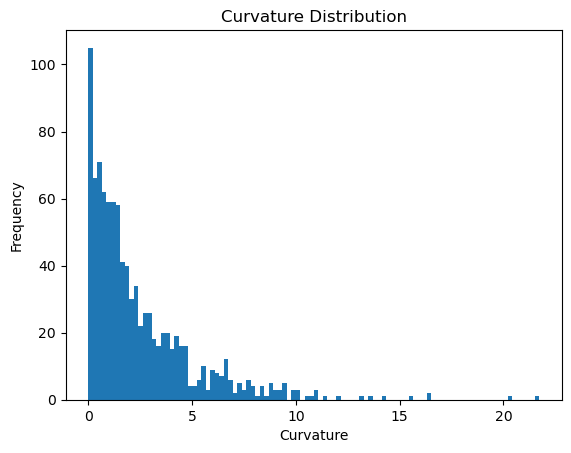

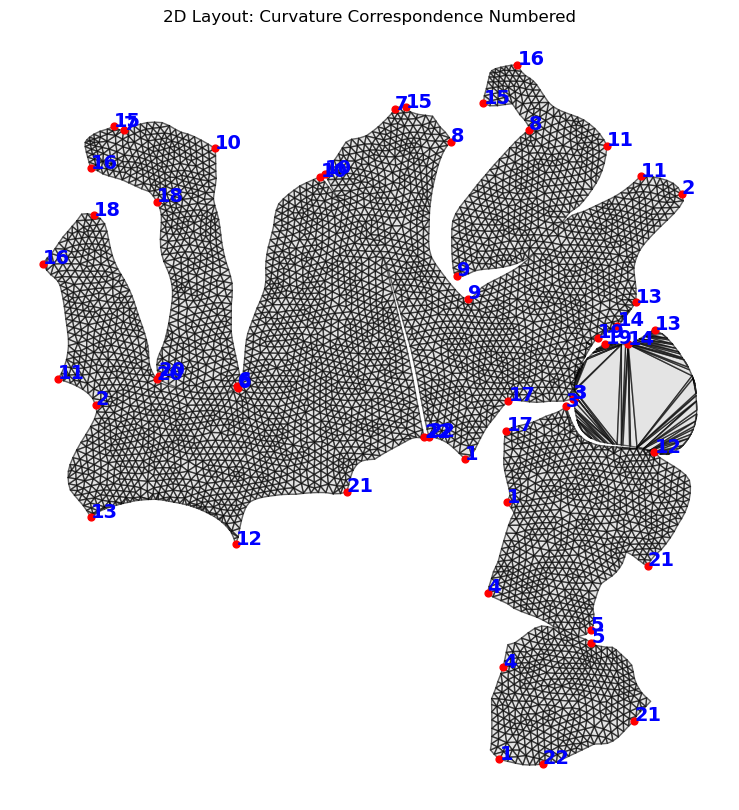

C:\Users\haona\AppData\Local\Temp\ipykernel_30968\3773256357.py:70: RuntimeWarning: invalid value encountered in cast
  return tuple(np.round(pt / q).astype(int))


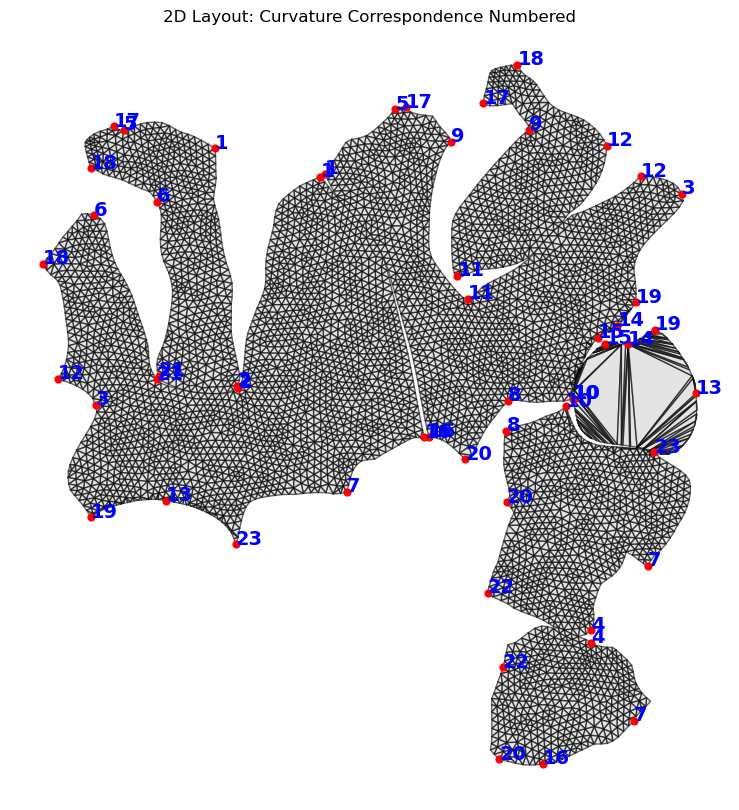

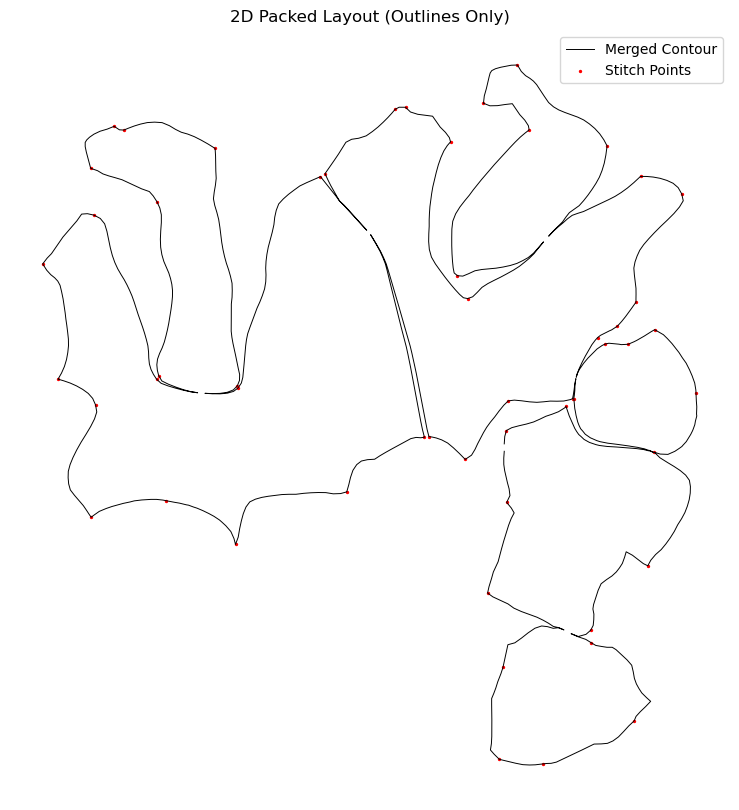

In [17]:
# [4.2] Convert local-space adjacency / correspondences into packed world coordinates.
# Outputs: adj_graph_2d_world, stitch_points_world, correspondence_map_world


adj_graph_2d_world = {}
for (i, j), edge_list in adj_graph_2d.items():
    R_i, t_i = best_layout[i]['R'], best_layout[i]['t']
    R_j, t_j = best_layout[j]['R'], best_layout[j]['t']
    transformed_edges = []
    for (e0, e1) in edge_list:
        pi0 = tuple(R_i @ np.array(e0[0]) + t_i)
        pi1 = tuple(R_i @ np.array(e0[1]) + t_i)
        pj0 = tuple(R_j @ np.array(e1[0]) + t_j)
        pj1 = tuple(R_j @ np.array(e1[1]) + t_j)
        transformed_edges.append(((pi0, pi1), (pj0, pj1)))
    adj_graph_2d_world[(i, j)] = transformed_edges


radius=0.007
stitch_points_world, correspondence_map_world = collect_high_curvature_points(
    contours_raw, best_layout, patches, adj_graph_2d, #adj_graph_2d_world,
    angle_min_deg=40,
    angle_max_deg=140,
    distance_threshold= radius/2
)


contours = build_contours_pieces(contours_raw, best_choice, adj_graph_2d)

contours_world = {}

for pid, polyline_list in contours.items():
    R, t = best_layout[pid]['R'], best_layout[pid]['t']
    transformed_polylines = []

    for polyline in polyline_list:
        transformed_polyline = []
        for pt in polyline:
            pt = np.array(pt, dtype=np.float64).flatten()
            if pt.shape[0] != 2:
                print(f"[Warning] Invalid point shape {pt.shape} in patch {pid}, pt = {pt}")
                continue
            pt_world = R @ pt + t
            transformed_polyline.append(pt_world)

        if transformed_polyline:
            transformed_polylines.append(np.array(transformed_polyline))

    if not transformed_polylines:
        raise ValueError(f"Patch {pid} has no valid polylines after transform!")

    contours_world[pid] = transformed_polylines

# _, merged_contour = merge_all_contours(contours_world)

merged_contour = build_single_outline_noq(
    best_layout,
    patches,
    patch_faces,  
    adj_graph_2d,
    best_choice,
    min_seg=0            
)

    
stitch_points_world, correspondence_map_world = add_midpoints_in_sparse_regions(
    merged_contour=merged_contour,
    stitch_points=stitch_points_world,
    correspondence_map=correspondence_map_world,
    adj_graph_2d=adj_graph_2d_world,
    min_gap=40,
    max_gap=60,
    max_insertions=2,
    close_gap=15,
    distance_threshold=radius/2
)


shifted_in_stitch_points = shift_stitch_points_along_edges(
    stitch_points_world, best_layout, patches, patch_faces, contours_raw, shift_eps=0.002, dir_ward="inward"
)

shifted_out_stitch_points = shift_stitch_points_along_edges(
    stitch_points_world, best_layout, patches, patch_faces, contours_raw, shift_eps=0.002, dir_ward="outward"
)



export_layout_with_stitch_points_to_dxf(best_layout, contours, shifted_in_stitch_points, filename='layout_with_stitch.dxf', scale=40.0)

contours_raw_world = {}
for pid, polyline_list in contours_raw.items():
    R, t = best_layout[pid]['R'], best_layout[pid]['t']
    contours_raw_world[pid] = [
        [(R @ np.array(pt) + t).tolist() for pt in polyline]
        for polyline in [polyline_list]
    ]

export_layout_with_stitch_vectors_to_svg(
    best_layout, shifted_out_stitch_points, contours_raw_world, contours, stitch_points_world, patches, patch_faces,
    target_width_mm=130.0,
    target_height_mm=100.0,
    padding_mm=5.0,
    svg_filename='Ball.svg',
    pdf_filename= None,
    contour_stroke_width='0.01pt',
    vector_stroke_width='0.01pt',
    cross_stroke_width=None,
    red_point_radius=None,
    stitch_hole_radius=None,
    border=None
)

export_layout_with_stitch_vectors_to_svg(
    best_layout, shifted_out_stitch_points, contours_raw_world, contours, stitch_points_world, patches, patch_faces,
    target_width_mm=300.0,
    target_height_mm=200.0,
    padding_mm=5.0,
    svg_filename=None,
    pdf_filename='Bir.pdf',
    contour_stroke_width='0.1pt',
    vector_stroke_width=None,
    cross_stroke_width=None,
    red_point_radius=None,
    stitch_hole_radius=None,
    border=None
)
export_layout_with_stitch_vectors_to_svg(
    best_layout, shifted_out_stitch_points, contours_raw_world, contours, stitch_points_world, patches, patch_faces,
    target_width_mm=130.0,
    target_height_mm=100.0,
    padding_mm=5.0,
    svg_filename=None,
    pdf_filename='Cross+border.pdf',
    contour_stroke_width=None,
    vector_stroke_width=None,
    cross_stroke_width='0.01pt',
    red_point_radius=None,
    stitch_hole_radius=None,
    border="0.01pt"
)

number2points = visualize_layout_with_point_pairs(
    patches,          
    patch_faces,      
    best_layout,           
    stitch_points_world,       
    correspondence_map_world, 
    adj_graph_2d,   
    contours,
    figsize=(10, 10) 
)
visualize_layout_with_points(
    patches,
    patch_faces,
    best_layout,
    stitch_points=stitch_points_world,
    merged_contour=merged_contour,
    figsize=(10, 10),
    outline_color='black',
    outline_lw=1.2,
    merged_color='black',
    merged_lw=0.7,
    stitch_color='red',
    stitch_size=2,
    title="2D Packed Layout (Outlines Only)"
)


In [ ]:
# =============================================================================
# 4.3 Routing the Lacing — Lacing Area Construction
# - Trace contour from joining edges to form initial lacing areas
# - Iteratively merge disconnected areas with increasing k
# - Output: areas (each area has matched point sequences)
# =============================================================================

In [ ]:
# [4.3] Index helper: map (patch_id, 2D position) to a global index for routing/search.

def find_index_by_patch_and_position(
    pt: Tuple[float, float],
    metadata: List[Tuple[int, Tuple[float, float]]],
    target_patch: int,
    tol=None
) -> int:
    pt_arr = np.array(pt)
    candidate_indices = [
        i for i, (pid, coord) in enumerate(metadata)
        if pid == target_patch
    ]
    if not candidate_indices:
        raise ValueError(f"No points for patch {target_patch} found in metadata")

    dists = [np.linalg.norm(np.array(metadata[i][1]) - pt_arr) for i in candidate_indices]
    best_i = candidate_indices[np.argmin(dists)]

    if tol is not None and min(dists) > tol:
        raise ValueError(f"Point {pt} not found near patch {target_patch} (min dist={min(dists):.6f})")

    return best_i




# [4.3] Trace one lacing area starting from a joining edge on the contour.
# Output: one area record containing matched point sequences (red/corresponding).

def extract_splicing_area(
    patchA: int,
    patchB: int,
    merged_contour: List[Tuple[int, Tuple[float, float]]],
    correspondence_map: Dict[Tuple[int, Tuple[float, float]], Set[Tuple[int, Tuple[float, float]]]],
    start_coord_A: Tuple[float, float],
    start_coord_B: Tuple[float, float],
    dir_A: int,
    dir_B: int,
    radius
) -> Tuple[List[Tuple[int, Tuple[float, float]]], List[Tuple[int, Tuple[float, float]]]]:

    
    N = len(merged_contour)
    idx_A = find_index_by_patch_and_position(start_coord_A, merged_contour, patchA)
    idx_B = find_index_by_patch_and_position(start_coord_B, merged_contour, patchB)

    region_A, region_B = [], []

    stitch_A = None
    stitch_B = None
    last_set_A = set()
    last_set_B = set()
    repeat_map = {}
#     repeat_A = False
#     repeat_B = False
    for _ in range(N):  
        pid_A, local_A = merged_contour[idx_A]
        pid_B, local_B = merged_contour[idx_B]

        key_A = (pid_A, local_A)
        key_B = (pid_B, local_B)
        if not stitch_A:
            if key_A in correspondence_map and not (correspondence_map[key_A] & last_set_A):
                stitch_A = key_A
            elif key_A in correspondence_map and (correspondence_map[key_A] & last_set_A):
                if all(np.linalg.norm(np.array(local_A) - np.array(pt[1])) > radius for pt in (correspondence_map[key_A] & last_set_A)):
    #                 repeat_A = True
                    if np.size(last_set_A)>=2:
                        raise ValueError("The size of last_set_A >= 2")
                    else:
                        repeat_map[last_set_A.pop()] = (pid_A+0.5, local_A)
                idx_A = (idx_A + dir_A) % N
            else:
                idx_A = (idx_A + dir_A) % N
                
        if not stitch_B:
            if key_B in correspondence_map and not (correspondence_map[key_B] & last_set_B):
                stitch_B = key_B
            elif key_B in correspondence_map and (correspondence_map[key_B] & last_set_B):
                if all(np.linalg.norm(np.array(local_B) - np.array(pt[1])) > radius for pt in (correspondence_map[key_B] & last_set_B)):
    #                 repeat_B = True
                    if np.size(last_set_B)>=2:
                        raise ValueError("The size of last_set_B >= 2")
                    else:
                        
                        repeat_map[last_set_B.pop()] = (pid_B+0.5, local_B)
                idx_B = (idx_B + dir_B) % N
            else:
                idx_B = (idx_B + dir_B) % N
        
#         if repeat_A:
#             #key_A = (key_A[0]+0.5, key_A[1])
#             if isinstance(region_A[-1], list):
#                 region_A[-1].append(key_A)
#             else:
#                 region_A[-1] = [region_A[-1], key_A]
#             repeat_A = False
#         if repeat_B:
#             #key_B = (key_B[0]+0.5, key_B[1])
#             if isinstance(region_B[-1], list):
#                 region_B[-1].append(key_B)
#             else:
#                 region_B[-1] = [region_B[-1], key_B]
#             repeat_B = False
        
        if (stitch_A is not None and stitch_B is not None):
            if key_B in correspondence_map[key_A]:
                region_A.append(key_A)
                region_B.append(key_B)
                stitch_A = None
                stitch_B = None
                idx_A = (idx_A + dir_A) % N
                idx_B = (idx_B + dir_B) % N
                last_set_A = set()
                last_set_B = set()
                last_set_A.add(key_A)
                last_set_B.add(key_B)
            else:
                break
        
        

    return region_A, region_B, repeat_map


# def extract_splicing_area(
#     patchA: int,
#     patchB: int,
#     merged_contour: List[Tuple[int, Tuple[float, float]]],
#     correspondence_map: Dict[Tuple[int, Tuple[float, float]], Set[Tuple[int, Tuple[float, float]]]],
#     start_coord_A: Tuple[float, float],
#     start_coord_B: Tuple[float, float],
#     dir_A: int,
#     dir_B: int
# ) -> Tuple[List[Tuple[int, Tuple[float, float]]], List[Tuple[int, Tuple[float, float]]]]:

#     N = len(merged_contour)
#     idx_A = find_index_by_patch_and_position(start_coord_A, merged_contour, patchA)
#     idx_B = find_index_by_patch_and_position(start_coord_B, merged_contour, patchB)

#     region_A, region_B = [], []

#     for _ in range(N):  
#         pid_A, local_A = merged_contour[idx_A]
#         pid_B, local_B = merged_contour[idx_B]

#         key_A = (pid_A, local_A)
#         key_B = (pid_B, local_B)

#         if pid_A != patchA or pid_B != patchB:
#             break 

#         if key_A in correspondence_map:
#             if key_B in correspondence_map[key_A]:
#                 region_A.append(key_A)
#                 region_B.append(key_B)
#             else:
#                 break
        
#         idx_A = (idx_A + dir_A) % N
#         idx_B = (idx_B + dir_B) % N

#     return region_A, region_B





# [4.3] Extract all lacing areas by repeatedly tracing from joining edges.
# Output: areas = list of area dicts, used by zigzag routing and bridge connection.

def extract_all_splicing_areas(
    best_choice: Dict[Tuple[int, int], int],
    adj_graph_2d: Dict[Tuple[int, int], List[Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]]],
    merged_contour: List[Tuple[int, Tuple[float, float]]],
    correspondence_map: Dict[Tuple[int, Tuple[float, float]], Set[Tuple[int, Tuple[float, float]]]],
    radius
) -> List[Dict]:
    repeat_map_list = []
    areas = []
    area_id = 0
    N = len(merged_contour)
    
    for (i, j), idx in best_choice.items():
        if (i, j) not in adj_graph_2d:
            continue

        edge_pair_list = adj_graph_2d[(i, j)]
        if idx >= len(edge_pair_list):
            continue 

        (pi0, pi1), (pj0, pj1) = edge_pair_list[idx]

        idx_pi1 = find_index_by_patch_and_position(pi1, merged_contour, i)
        idx_pj1 = find_index_by_patch_and_position(pj1, merged_contour, j)
        if idx_pi1 is None or idx_pj1 is None:
            continue

        if (idx_pj1 - idx_pi1) % N == 1:
            dir_A, dir_B = -1, 1  
        elif (idx_pi1 - idx_pj1) % N == 1:
            dir_A, dir_B = 1, -1  
        else:
            continue 

        seq_A, seq_B, repeat_map1 = extract_splicing_area(
            i, j, merged_contour, correspondence_map,
            tuple(pi1), tuple(pj1), dir_A, dir_B,
            radius
        )
        repeat_map_list.append((area_id, repeat_map1))
        if seq_A and seq_B:
            areas.append({
                'area_id': area_id,
                'splicing_point': [(i, pi0), (j, pj0)],
                'patch_pair': (i, j),
                'source_patch': i,
                'stitch_sequence': seq_A,
                'corresponding_sequence': seq_B
            })
            area_id += 1

        idx_pj0 = find_index_by_patch_and_position(pj0, merged_contour, j)
        idx_pi0 = find_index_by_patch_and_position(pi0, merged_contour, i)
        if idx_pj0 is None or idx_pi0 is None:
            continue

        if (idx_pi0 - idx_pj0) % N == 1:
            dir_A_rev, dir_B_rev = -1, 1   
        elif (idx_pj0 - idx_pi0) % N == 1:
            dir_A_rev, dir_B_rev = 1, -1  
        else:
            continue 

        seq_B, seq_A, repeat_map2 = extract_splicing_area(
            j, i, merged_contour, correspondence_map,
            tuple(pj0), tuple(pi0), dir_A_rev, dir_B_rev,
            radius
        )
        repeat_map_list.append((area_id, repeat_map2))
        if seq_A and seq_B:
            areas.append({
                'area_id': area_id,
                'splicing_point': [(j, pj0), (i, pi0)],
                'patch_pair': (j, i),
                'source_patch': j,
                'stitch_sequence': seq_B,
                'corresponding_sequence': seq_A
            })
            area_id += 1
        
    return areas, repeat_map_list
   
    
def visualize_splicing_areas(
    areas, 
    merged_contour=None, 
    correspondence_map=None, 
    figsize=(10, 10),
    show_labels=True
):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np

    fig, ax = plt.subplots(figsize=figsize)
    cmap = cm.get_cmap('tab10', max(len(areas), 10))


    # blue lines
    if merged_contour is not None:
        poly = np.array([pt[1] for pt in merged_contour])
        ax.plot(poly[:, 0], poly[:, 1], '-', color='blue', linewidth=0.8, alpha=0.5, label="merged_contour")

    # stitch points
    if correspondence_map is not None:
        red_pts = np.array([list(coord) for (_, coord) in correspondence_map.keys()])
        ax.plot(red_pts[:, 0], red_pts[:, 1], '.', color='red', alpha=0.3, markersize=3, label='all red points')

    for area in areas:
        area_id = area['area_id']
        color = cmap(area_id % 10)

        seqA = area['stitch_sequence']
        seqB = area['corresponding_sequence']

        # Patch A
        if seqA:
            coordsA = np.array([pt[1] for pt in seqA])
            if len(coordsA) > 1:
                ax.plot(coordsA[:, 0], coordsA[:, 1], '-', color=color, linewidth=1.5)
            ax.plot(coordsA[:, 0], coordsA[:, 1], 'o', color=color, markersize=12, markeredgecolor='red', label=f'A{area_id}')

            if show_labels:
                for k, pt in enumerate(coordsA):
                    ax.text(pt[0], pt[1], f'A{area_id}-{k}', color=color, fontsize=6)

        # Patch B
        if seqB:
            coordsB = np.array([pt[1] for pt in seqB])
            if len(coordsB) > 1:
                ax.plot(coordsB[:, 0], coordsB[:, 1], '--', color=color, linewidth=1.5)
            ax.plot(coordsB[:, 0], coordsB[:, 1], 'x', color=color, markersize=12, markeredgecolor='red', label=f'B{area_id}')

            if show_labels:
                for k, pt in enumerate(coordsB):
                    ax.text(pt[0], pt[1], f'B{area_id}-{k}', color=color, fontsize=6)

    ax.set_aspect('equal')
    ax.set_title("Detailed Splicing Area Red Points")
    ax.legend(fontsize=6, loc='upper right')
    plt.tight_layout()
    plt.show()




def filter_close_point_areas(areas: List[Dict], threshold: float = 1e-3) -> List[Dict]:
    filtered = []
    for area in areas:
        seq_A = area['stitch_sequence']
        seq_B = area['corresponding_sequence']
        assert len(seq_A) == len(seq_B), "the length of stitch_sequence and corresponding_sequence are different!!!"

        new_seq_A = []
        new_seq_B = []

        for (pidA, ptA), (pidB, ptB) in zip(seq_A, seq_B):
            dist = np.linalg.norm(np.array(ptA) - np.array(ptB))
            if dist >= threshold:
                new_seq_A.append((pidA, ptA))
                new_seq_B.append((pidB, ptB))

        if len(new_seq_A) > 0:
            new_area = area.copy()
            new_area['stitch_sequence'] = new_seq_A
            new_area['corresponding_sequence'] = new_seq_B
            filtered.append(new_area)

    return filtered


def filter_overlapping_areas(areas_save: List[Dict]) -> List[Dict]:
    n = len(areas)
    keep_flags = [True] * n
    area_sets = []

    for area in areas:
        combined_seq = area['stitch_sequence'] + area['corresponding_sequence']
        area_sets.append(set(combined_seq))

    for i in range(n):
        if not keep_flags[i]:
            continue
        for j in range(i + 1, n):
            if not keep_flags[j]:
                continue
            if len(area_sets[i] & area_sets[j]) > 1:
                len_i = len(area_sets[i])
                len_j = len(area_sets[j])

                if len_i > len_j:
                    keep_flags[j] = False
                elif len_j > len_i:
                    keep_flags[i] = False
                    break
                else:
                    pt_i1 = np.array(areas[i]['stitch_sequence'][0][1])
                    pt_i2 = np.array(areas[i]['corresponding_sequence'][0][1])
                    pt_j1 = np.array(areas[j]['stitch_sequence'][0][1])
                    pt_j2 = np.array(areas[j]['corresponding_sequence'][0][1])

                    dist_i = np.linalg.norm(pt_i1 - pt_i2)
                    dist_j = np.linalg.norm(pt_j1 - pt_j2)

                    if dist_i >= dist_j:
                        keep_flags[j] = False
                    else:
                        keep_flags[i] = False
                        break

    filtered_areas = [area for area, keep in zip(areas, keep_flags) if keep]
    return filtered_areas

areas_raw, repeat_map_list = extract_all_splicing_areas(
    best_choice,
    adj_graph_2d_world,
    merged_contour,
    correspondence_map_world,
    radius=0.001
)
print(repeat_map_list)
areas = areas_raw

areas = filter_overlapping_areas(areas)
def filter_single_point_areas(areas: List[Dict]) -> List[Dict]:

    filtered_areas = [
        area for area in areas
        if len(area['stitch_sequence']) > 1 or len(area['corresponding_sequence']) > 1
    ]
    return filtered_areas

areas = filter_single_point_areas(areas)

visualize_splicing_areas(
    areas=areas,
    merged_contour=merged_contour, 
    correspondence_map=correspondence_map_world,
    show_labels=True
)

valid_area_ids = {area['area_id'] for area in areas}

filtered_repeat_map_list = [
    (idx, content) for idx, content in repeat_map_list 
    if idx in valid_area_ids and content
]
filtered_repeat_map_list
repeat_map = {**{k: v for _, d in filtered_repeat_map_list if d for k, v in d.items()}}

In [ ]:
# ==================================== HELP FUNCTIONS FOR REROUTING ZIGZAG TENDON ====================================
def is_intersect_zigzag(seg1, seg2, close=False, tol=0.001):
    
    if isinstance(seg1[0], np.ndarray):
        p1 = seg1[0]
        p2 = seg1[1]
    else:
        p1 = np.array(seg1[0][1])
        p2 = np.array(seg1[1][1])
    if isinstance(seg2[1], np.ndarray):
        q1 = seg2[0]
        q2 = seg2[1]
    else:
        q1 = np.array(seg2[0][1])
        q2 = np.array(seg2[1][1])

    line1 = LineString([p1, p2])
    line2 = LineString([q1, q2])

    if not line1.intersects(line2):
        if close:
            if line2.distance(Point(p1)) < tol or line2.distance(Point(p2)) < tol:
                return True
            if line1.distance(Point(q1)) < tol or line1.distance(Point(q2)) < tol:
                return True
        return False


    inter = line1.intersection(line2)

    if inter.geom_type == 'Point':
        pt = (inter.x, inter.y)

        is_on_p = any(np.linalg.norm(np.array(pt) - ep) < 1e-8 for ep in [p1, p2])
        is_on_q = any(np.linalg.norm(np.array(pt) - ep) < 1e-8 for ep in [q1, q2])
        return not (is_on_p and is_on_q)

    return True

def is_colinear(A, B, C, D, angle_threshold=5):

    v1 = B - A
    v2 = D - C
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)

    if norm1 < 1e-6 or norm2 < 1e-6:
        return False

    cos_theta = np.dot(v1, v2) / (norm1 * norm2)
    angle_deg = math.degrees(math.acos(np.clip(cos_theta, -1.0, 1.0)))
    return angle_deg < angle_threshold or angle_deg > (180 - angle_threshold)

def cross_2d(a, b):
    return a[0] * b[1] - a[1] * b[0]

def is_same_side(K1, K2, P1, P2):

    v  = K2 - K1
    v1 = P1 - K1
    v2 = P2 - K1

    cross1 = cross_2d(v, v1)
    cross2 = cross_2d(v, v2)

    return cross1 * cross2 > 0

def extend_along_direction(src, tgt, epsilon=0.5):
    direction = tgt - src
    norm = np.linalg.norm(direction)
    if norm < 1e-8:
        print(src, tgt)
        raise ValueError("Too close to determine direction.")
    direction /= norm
    return src + direction * (norm + epsilon)

def compute_foot_point(P, A, B, inside=False):
    P = np.array(P)
    A = np.array(A)
    B = np.array(B)

    AB = B - A
    AP = P - A
    AB_norm_sq = np.dot(AB, AB)

    if AB_norm_sq < 1e-10:
        return A 

    proj_len = np.dot(AP, AB) / AB_norm_sq
    
    if inside:
        if proj_len < -1e-5 or proj_len > 1+1e-5:
            return None
    
    H = A + proj_len * AB
    return H


In [ ]:
# =============================================================================
# 4.3 Routing the Lacing — Zigzag + Detour
# - Generate zigzag path inside each lacing area
# - When a new segment intersects accepted segments, reroute locally (detour)
# =============================================================================

In [ ]:
# [4.3] Local detour for a zigzag segment to avoid intersections with accepted segments.
# Convention: accepted_segments stores already committed segments (each is two 2D endpoints).

def reroute_zigzag(
    positive_direction_right,
    accepted_segments,
    pt_start,
    pt_prev,               
    pt_curr,  
    intersection_seg,
    stitch_points_world,
    epsilon=0.5,
    radius=1.0
):
    B = np.array(pt_prev[1])
    C = np.array(pt_curr[1])
    S = np.array(pt_start)
    pid = -1
    
    detour_pts = n_points_detour(positive_direction_right, accepted_segments, intersection_seg, C, S, epsilon=epsilon, radius=radius, strategy="full")
    reroute = [pt_prev] + [(-1, tuple(p)) for p in detour_pts] + [pt_curr]
    return reroute
    
    


def find_intersecting_stitch_point(stitch_points_world, seg, radius=0.5):
    seg_start, seg_end = seg
    # stitch_points_world_tuple = [(pid, tuple(pt)) for pid, pt in stitch_points_world]
    stitch_points_world_array = [np.array(pt) for _, pt in stitch_points_world]
    for p in stitch_points_world_array:
        if np.array_equal(p, seg_start) or np.array_equal(p, seg_end):
            continue
        if is_intersect_zigzag_circle(p, seg, radius=radius):
            return p
    return None


# ==================================== GENERATING ZIGZAG ====================================


def is_intersect_zigzag_circle(
    center_point,
    segment,
    radius=0.5
) -> bool:

    if isinstance(center_point, tuple) and isinstance(center_point[1], (np.ndarray, tuple)):
        pt_center = tuple(center_point[1]) if isinstance(center_point[1], np.ndarray) else center_point[1]
    else:
        pt_center = tuple(center_point) if isinstance(center_point, np.ndarray) else center_point

    pt1_raw = segment[0]
    if isinstance(pt1_raw, tuple) and isinstance(pt1_raw[1], (np.ndarray, tuple)):
        pt1 = tuple(pt1_raw[1]) if isinstance(pt1_raw[1], np.ndarray) else pt1_raw[1]
    else:
        pt1 = tuple(pt1_raw) if isinstance(pt1_raw, np.ndarray) else pt1_raw

    pt2_raw = segment[1]
    if isinstance(pt2_raw, tuple) and isinstance(pt2_raw[1], (np.ndarray, tuple)):
        pt2 = tuple(pt2_raw[1]) if isinstance(pt2_raw[1], np.ndarray) else pt2_raw[1]
    else:
        pt2 = tuple(pt2_raw) if isinstance(pt2_raw, np.ndarray) else pt2_raw

    circle = Point(pt_center).buffer(radius)
    line = LineString([pt1, pt2])
    return circle.intersects(line)

def is_point_in_quad(edge1, edge2, point) -> bool:

    pt1 = np.array(edge1[0][1])
    pt2 = np.array(edge1[1][1])
    pt3 = np.array(edge2[0][1])
    pt4 = np.array(edge2[1][1])
    test_pt = np.array(point[1])

    quad = Polygon([pt1, pt2, pt4, pt3])  
    if not quad.is_valid:
        quad = Polygon([pt1, pt2, pt3, pt4])  
    return quad.contains(Point(test_pt)) or quad.touches(Point(test_pt))
def is_left(O, R, P, tol=1e-8):
    O, R, P = np.asarray(O), np.asarray(R), np.asarray(P)
    d = R - O
    OP = P - O
    cross = np.cross(d, OP)  
    
    if abs(cross) < tol:
        return "on the ray"
    return cross > 0  # True=left
def direction_reroute(i, raw_path, pt_start):        
    if is_left(np.array(raw_path[0][1]),np.array(raw_path[1][1]),np.array(pt_start)):
        if (i%2==0 and is_left(np.array(raw_path[i - 2][1]),np.array(raw_path[i-1][1]),np.array(raw_path[i][1]))):
            return True
        elif (i%2!=0 and not is_left(np.array(raw_path[i - 2][1]),np.array(raw_path[i-1][1]),np.array(raw_path[i][1]))):
            return True
        else:
            return False
    else:
        if (i%2==0 and is_left(np.array(raw_path[i - 2][1]),np.array(raw_path[i-1][1]),np.array(raw_path[i][1]))):
            return False
        elif (i%2!=0 and not is_left(np.array(raw_path[i - 2][1]),np.array(raw_path[i-1][1]),np.array(raw_path[i][1]))):
            return False
        else:
            return True


def generate_zigzag_path_simple(area: Dict, mode: int = 0) -> List[Tuple[int, Tuple[float, float]]]:
   

    seqA = area['stitch_sequence']
    seqB = area['corresponding_sequence']

    if len(seqA) != len(seqB):
        raise ValueError(f"Area {area['area_id']} stitch/corresponding sequence length are different, cannot do zigzag.")

    if mode in [2, 3]:
        seqA = seqA[::-1]
        seqB = seqB[::-1]

    path = []
    if mode % 2 == 0:
        # A first
        for a, b in zip(seqA, seqB):
            path.append(a)
            path.append(b)
    else:
        # B first
        for a, b in zip(seqA, seqB):
            path.append(b)
            path.append(a)

    return path

def visualize_zigzag_paths(zigzag_paths, contours_raw, figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    
    from matplotlib import colormaps
    cmap = colormaps['tab10'].resampled(len(zigzag_paths))

    x_all, y_all = [], []
    for contour in contours_raw.values():
        contour = np.array(contour)
        if len(contour.shape) > 2:
            contour = contour[0]
        x_all.extend(contour[:, 0])
        y_all.extend(contour[:, 1])

    for path_data in zigzag_paths:
        for _, (x, y) in path_data['point_seq']:
            x_all.append(x)
            y_all.append(y)

    x_min, x_max = min(x_all), max(x_all)
    y_min, y_max = min(y_all), max(y_all)
    x_range = x_max - x_min
    y_range = y_max - y_min
    margin_ratio = 0.1

    ax.set_xlim(x_min - x_range * margin_ratio, x_max + x_range * margin_ratio)
    ax.set_ylim(y_min - y_range * margin_ratio, y_max + y_range * margin_ratio)

    for pid, contour in contours_raw.items():
        contour = np.array(contour)
        if len(contour.shape) > 2:
            contour = contour[0]
        if not np.allclose(contour[0], contour[-1], atol=1e-6):
            contour = np.vstack([contour, contour[0]])
        ax.plot(contour[:, 0], contour[:, 1], '-', color='gray', linewidth=0.5, label='Contour' if pid == 0 else "")

    start_markers = []  
    end_markers = []   
    
    for path_data in zigzag_paths:
        area_id = path_data['area_id']
        path = path_data['point_seq']
        color = cmap(area_id % 10)
        
        if not path:
            continue

        for i in range(len(path) - 1):
            x0, y0 = path[i][1]
            x1, y1 = path[i + 1][1]
            ax.annotate(
                '', xy=(x1, y1), xytext=(x0, y0),
                arrowprops=dict(arrowstyle='->', color=color, lw=1)
            )

        x_start, y_start = path[0][1]
        start = ax.plot(x_start, y_start, 'o', color='red', markersize=6)
        if area_id == 0:
            start_markers = start 

        x_end, y_end = path[-1][1]
        end = ax.plot(x_end, y_end, 's', color='blue', markersize=6)
        if area_id == 0:
            end_markers = end

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='gray', lw=1, label='Contour'),
        Line2D([0], [0], marker='o', color='red', label='Start Point',
               markersize=6, linestyle=''),
        Line2D([0], [0], marker='s', color='blue', label='End Point',
               markersize=6, linestyle='')
    ]
    ax.legend(handles=legend_elements)

    ax.set_aspect('equal')
    ax.set_title("Zigzag Path Visualization")
    plt.tight_layout()
    plt.show()
    
    
    
def generate_expanded_path_2(stitch_path, expanded_path, stitch_points_world, 
                            shifted_in_stitch_points, is_bridge, best_modes, offset=0.5):
    sp_index_map = {(pid, tuple(pt)): idx for idx, (pid, pt) in enumerate(stitch_points_world)}
    new_path = []
    n = len(expanded_path)
    prev_bridge = -0.5
    cnt = -1
    current_mode = None
    
    for i, item in enumerate(expanded_path):
        if isinstance(item, list) and len(item) == 2:
            # Update mode when encountering a new bridge segment
            if i < len(is_bridge) and is_bridge[i] < 0 and is_bridge[i] != prev_bridge:
                prev_bridge = is_bridge[i]
                cnt += 1
                current_mode = best_modes[cnt]
            
            (pid1, B1), (pid2, B2) = item
            key = stitch_path[i]
            key = (int(key[0]), key[1])
            idx = sp_index_map[key]
            
            # Calculate direction vector
            original = np.array(key[1])
            shifted = shifted_in_stitch_points[idx][1]
            direction = shifted - original
            norm = np.linalg.norm(direction)
            if norm > 1e-8:
                direction = direction / norm
            else:
                direction = np.array([1.0, 0.0])
            
            # Generate candidate points
            candidates_B0 = [
                np.array(B1) + offset * direction,
                np.array(B1) - offset * direction,
            ]
            candidates_B3 = [
                np.array(B2) + offset * direction,
                np.array(B2) - offset * direction,
            ]
            
            # Create rectangle polygon
            rect_poly = Polygon([
                tuple(candidates_B0[0]), tuple(candidates_B3[0]),
                tuple(candidates_B3[1]), tuple(candidates_B0[1])
            ])
            
            # Get previous and next points
            ptA = new_path[-1][-1][1] if i > 0 and isinstance(new_path[-1], list) else (
                new_path[-1][1] if i > 0 else None)
            ptC = expanded_path[i + 1][0][1] if i + 1 < n and isinstance(expanded_path[i + 1], list) else (
                expanded_path[i + 1][1] if i + 1 < n else None)
            
            # Determine B0 and B3 based on mode
            B0, B3, B00, B33, evil_A, evil_C = determine_connection_points(
                ptA, ptC, B1, B2, pid1, pid2, candidates_B0, candidates_B3, 
                rect_poly, current_mode
            )
            
            # Build result path
            result = build_result_path(
                B0, B3, B00, B33, pid1, pid2, B1, B2, evil_A, evil_C, current_mode
            )
            
            new_path.append(result)
        else:
            new_path.append(item)
    
    return new_path



def determine_connection_points(ptA, ptC, B1, B2, pid1, pid2, candidates_B0, 
                               candidates_B3, rect_poly, mode):
    B0, B3, B00, B33 = None, None, None, None
    evil_A, evil_C = False, False

    if mode > 1:
        temp_ptA, temp_ptC = ptC, ptA
        temp_B1, temp_B2 = B2, B1
        temp_pid1, temp_pid2 = pid2, pid1
        temp_candidates_B0 = candidates_B3
        temp_candidates_B3 = candidates_B0

        temp_B0, temp_B3, temp_B00, temp_B33, temp_evil_C, temp_evil_A = determine_connection_points(
            temp_ptA, temp_ptC, temp_B1, temp_B2, temp_pid1, temp_pid2, 
            temp_candidates_B0, temp_candidates_B3, rect_poly, mode-2
        )
        
        B0 = temp_B3
        B3 = temp_B0
        B00 = temp_B33
        B33 = temp_B00
        evil_A = temp_evil_C
        evil_C = temp_evil_A
        
        return B0, B3, B00, B33, evil_A, evil_C
    
    # Handle B0 selection
    if ptA is not None:
        lineA = LineString([ptA, B1])
        intersection_A = rect_poly.intersection(lineA)
        if rect_poly.intersects(lineA) and not is_tangent_intersection(intersection_A, B1):

            angles = [angle_between(ptA, B1, cand) for cand in candidates_B0]
            idx = int(np.argmin(angles))
            candidate_B0 = candidates_B0[idx]
            alt_candidate_B0 = candidates_B0[1 - idx]
            
            
            
            
            B0 = (pid1, tuple(candidate_B0.tolist()))
            
            # Handle cases where ptA is outside rectangle
            if not rect_poly.contains(Point(ptA)):
                lineAA = LineString([ptA, np.array(B0[1])])
                if rect_poly.intersects(lineAA):
                    inter = rect_poly.intersection(lineAA)
                    if not is_tangent_intersection(inter, B0[1]):
                        angles = [angle_between(ptA, cand, B0[1]) for cand in candidates_B3]
                        B33_candidate = candidates_B3[int(np.argmax(angles))]
                        alt_B33_candidate = candidates_B3[int(np.argmin(angles))]

                        if ptC is not None:
                            line_A_to_B33 = LineString([ptA, B33_candidate])
                            line_B33_to_B0 = LineString([B33_candidate, B0[1]])
                            line_B2_to_ptC = LineString([B2, ptC])
                            
                            if (line_A_to_B33.intersects(line_B2_to_ptC) or 
                                line_B33_to_B0.intersects(line_B2_to_ptC)):
                                B33_candidate = alt_B33_candidate
                        
                        B33 = (pid1, tuple(B33_candidate.tolist()))
                        
                        if is_intersect_zigzag((np.array(B2), np.array(B1)), 
                                              (np.array(B33[1]), np.array(B0[1]))):
                            B33 = (pid1, tuple(alt_B33_candidate.tolist()))
                        
                        if is_intersect_zigzag((np.array(B2), np.array(B1)), 
                                              (np.array(B33[1]), np.array(ptA)), close=True, tol=1e-3):
                            evil_A = True
            elif ptC is not None:
                if is_intersect_zigzag((np.array(ptA), np.array(B1)), (np.array(B2), np.array(ptC))):
                    angles = [angle_between(ptA, cand, B1) for cand in candidates_B0]
                    B0 = (pid1, tuple(candidates_B0[int(np.argmin(angles))].tolist()))
                    
                    angles1 = [angle_between(ptA, B1, cand) for cand in candidates_B3]
                    B33 = (pid1, tuple(candidates_B3[int(np.argmax(angles1))].tolist()))
                    evil_A = True
                    

                        

    # Handle B3 selection
    if ptC is not None:
        lineC = LineString([ptC, B2])
        intersection_C = rect_poly.intersection(lineC)
        if rect_poly.intersects(lineC) and not is_tangent_intersection(intersection_C, B2):
            angles = [angle_between(ptC, cand, B2) for cand in candidates_B3]
            candidate_B3 = candidates_B3[int(np.argmax(angles))]
            alt_candidate_B3 = candidates_B3[int(np.argmin(angles))]

            if ptA is not None:
                line_B3_to_ptC = LineString([candidate_B3, ptC])
                line_A_to_B1 = LineString([ptA, B1])
                
                if line_B3_to_ptC.intersects(line_A_to_B1):
                    candidate_B3 = alt_candidate_B3
            
            B3 = (pid2, tuple(candidate_B3.tolist()))

            if ptA is not None:
                if is_intersect_zigzag((np.array(ptA), np.array(B1)), (np.array(B2), np.array(ptC))):
                    B3 = (pid2, tuple(alt_candidate_B3.tolist()))

            if not rect_poly.contains(Point(ptC)):
                lineBB = LineString([ptC, np.array(B3[1])])
                if rect_poly.intersects(lineBB):
                    inter = rect_poly.intersection(lineBB)
                    if not is_tangent_intersection(inter, B3[1]):
                        angles = [angle_between(ptC, cand, B3[1]) for cand in candidates_B0]
                        B00_candidate = candidates_B0[int(np.argmax(angles))]
                        alt_B00_candidate = candidates_B0[int(np.argmin(angles))]

                        if ptA is not None:
                            line_B00_to_ptC = LineString([B00_candidate, ptC])
                            line_A_to_B1 = LineString([ptA, B1])
                            
                            if line_B00_to_ptC.intersects(line_A_to_B1):
                                B00_candidate = alt_B00_candidate
                        
                        B00 = (pid2, tuple(B00_candidate.tolist()))
                        
                        if is_intersect_zigzag((np.array(B2), np.array(B1)), 
                                              (np.array(B00[1]), np.array(B3[1]))):
                            B00 = (pid1, tuple(alt_B00_candidate.tolist()))
                        
                        if is_intersect_zigzag((np.array(B2), np.array(B1)), 
                                              (np.array(B00[1]), np.array(ptC))):
                            evil_C = True
            elif ptA is not None:
                if is_intersect_zigzag((np.array(ptA), np.array(B1)), (np.array(B2), np.array(ptC))):
                    angles = [angle_between(ptC, cand, B2) for cand in candidates_B3]
                    B3 = (pid2, tuple(candidates_B3[int(np.argmin(angles))].tolist()))
                    
                    angles1 = [angle_between(ptC, B2, cand) for cand in candidates_B0]
                    B00 = (pid2, tuple(candidates_B0[int(np.argmax(angles1))].tolist()))
                    evil_C = True
    
    
    if all(x is None for x in [B0, B3, B00, B33]):
        return B0, B3, B00, B33, evil_A, evil_C
    if ptA is not None and ptC is not None:
        path1_segments = []
        if B33 is not None:
            path1_segments.append((np.array(ptA), np.array(B33[1])))
            path1_segments.append((np.array(B33[1]), np.array(B0[1])))
            path1_segments.append((np.array(B0[1]), np.array(B1)))
        elif B0 is not None:
            path1_segments.append((np.array(ptA), np.array(B0[1])))
            path1_segments.append((np.array(B0[1]), np.array(B1)))
        else:
            path1_segments.append((np.array(ptA), np.array(B1)))

        path2_segments = []

        if B00 is not None:
            path2_segments.append((np.array(B1), np.array(B2)))
            path2_segments.append((np.array(B2), np.array(B3[1])))
            path2_segments.append((np.array(B3[1]), np.array(B00[1])))
            path2_segments.append((np.array(B00[1]), np.array(ptC)))
        elif B3 is not None:
            path2_segments.append((np.array(B1), np.array(B2)))
            path2_segments.append((np.array(B2), np.array(B3[1])))
            path2_segments.append((np.array(B3[1]), np.array(ptC)))
        else:
            path2_segments.append((np.array(B1), np.array(B2)))
            path2_segments.append((np.array(B2), np.array(ptC)))

        collision_detected = False
        for seg1 in path1_segments:
            for seg2 in path2_segments:
                if is_intersect_zigzag(seg1, seg2):
                    collision_detected = True
                    break
            if collision_detected:
                break

        if collision_detected and B0 is not None:
            idx = next((i for i, cand in enumerate(candidates_B0) if np.array_equal(cand, np.array(B0[1]))), None)
            candidate_B0 = candidates_B0[1 - idx]
            B0 = (pid1, tuple(candidate_B0.tolist()))
            
            if not rect_poly.contains(Point(ptA)):
                lineAA = LineString([ptA, np.array(B0[1])])
                if rect_poly.intersects(lineAA):
                    inter = rect_poly.intersection(lineAA)
                    if not is_tangent_intersection(inter, B0[1]):
                        angles = [angle_between(ptA, cand, B0[1]) for cand in candidates_B3]
                        B33_candidate = candidates_B3[int(np.argmax(angles))]
                        alt_B33_candidate = candidates_B3[int(np.argmin(angles))]
                        
                        if ptC is not None:
                            line_A_to_B33 = LineString([ptA, B33_candidate])
                            line_B33_to_B0 = LineString([B33_candidate, B0[1]])
                            line_B2_to_ptC = LineString([B2, ptC])
                            
                            if (line_A_to_B33.intersects(line_B2_to_ptC) or 
                                line_B33_to_B0.intersects(line_B2_to_ptC)):
                                B33_candidate = alt_B33_candidate
                        
                        B33 = (pid1, tuple(B33_candidate.tolist()))
                        
                        if is_intersect_zigzag((np.array(B2), np.array(B1)), 
                                              (np.array(B33[1]), np.array(B0[1]))):
                            B33 = (pid1, tuple(alt_B33_candidate.tolist()))
                        
                        if is_intersect_zigzag((np.array(B2), np.array(B1)), 
                                              (np.array(B33[1]), np.array(ptA)), close=True, tol=1e-3):
                            evil_A = True
            elif ptC is not None:
                if is_intersect_zigzag((np.array(ptA), np.array(B1)), (np.array(B2), np.array(ptC))):
                    angles = [angle_between(ptA, cand, B1) for cand in candidates_B0]
                    B0 = (pid1, tuple(candidates_B0[int(np.argmin(angles))].tolist()))
                    
                    angles1 = [angle_between(ptA, B1, cand) for cand in candidates_B3]
                    B33 = (pid1, tuple(candidates_B3[int(np.argmax(angles1))].tolist()))
                    evil_A = True
    
    return B0, B3, B00, B33, evil_A, evil_C

def build_result_path(B0, B3, B00, B33, pid1, pid2, B1, B2, evil_A, evil_C, mode):
    result = []
    
    # Add B33 with mode-specific adjustments
    if B33 is not None:
        if mode > 1 and evil_A:
            dis1 = np.linalg.norm(np.array(B0[1]) - np.array(B33[1])) * 0.2
            pt1 = extend_along_direction(np.array(B0[1]), np.array(B33[1]), dis1)
            pt1d5 = extend_along_direction(np.array(B1), np.array(B2), dis1)
            dis2 = np.linalg.norm(pt1d5 - pt1)
            pt2 = extend_along_direction(pt1, pt1d5, dis2 + dis1)
            result.extend([(pid1, tuple(pt2)), (pid1, tuple(pt1))])
        result.append(B33)
    
    # Add main points
    if B0 is None and B3 is None:
        result.extend([(pid1, B1), (pid2, B2)])
    elif B0 is None:
        result.extend([(pid1, B1), (pid2, B2), B3])
    elif B3 is None:
        result.extend([B0, (pid1, B1), (pid2, B2)])
    else:
        result.extend([B0, (pid1, B1), (pid2, B2), B3])
    
    # Add B00 with mode-specific adjustments
    if B00 is not None:
        if mode <= 1 and evil_C:
            dis1 = np.linalg.norm(np.array(B3[1]) - np.array(B00[1])) * 0.2
            pt1 = extend_along_direction(np.array(B3[1]), np.array(B00[1]), dis1)
            pt1d5 = extend_along_direction(np.array(B2), np.array(B1), dis1)
            dis2 = np.linalg.norm(pt1d5 - pt1)
            pt2 = extend_along_direction(pt1, pt1d5, dis2 + dis1)
            result.extend([(pid2, tuple(pt1)), (pid2, tuple(pt2))])
        else:
            result.append(B00)
    
    return result

def is_tangent_intersection(intersection, point):
    return (intersection.geom_type == "Point" and 
            intersection.distance(Point(point)) < 1e-4)




def angle_between(p1, p2, p3):

    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot = np.dot(v1, v2)
    norm = np.linalg.norm(v1) * np.linalg.norm(v2)
    if norm < 1e-8:
        return 0.0
    cos_theta = np.clip(dot / norm, -1.0, 1.0)
    return np.arccos(cos_theta)

def generate_expanded_path(
    stitch_path,
    stitch_points_world,
    shifted_out_stitch_points,
    is_bridge,
    best_modes,
    offset: float = 0.2
):
    
    # Create mapping from (pid, point) to index
    sp_index_map = {
        (pid, tuple(pt)): idx
        for idx, (pid, pt) in enumerate(stitch_points_world)
    }
    
    new_path = []
    current_zigzag_order = 1  # 1 for left-right, -1 for right-left
    n = len(stitch_path)
    cnt = -1
    prev_bridge = -0.5
    
    for i, (pid, pt) in enumerate(stitch_path):
        if pid < 0:
            new_path.append((pid, pt))
            continue
        
        # Check if this is the start of a new zigzag segment
        if i < len(is_bridge) and is_bridge[i] < 0 and is_bridge[i] != prev_bridge:
            prev_bridge = is_bridge[i]
            current_zigzag_order = 1  # Reset to left-right order for new segment
            cnt += 1
            
            
        if i < len(is_bridge) and is_bridge[i] == 1:
            new_path.append((pid, pt))
            continue
        key = (int(pid), pt)
    
        if key in sp_index_map:
            idx = sp_index_map[key]
            original = np.array(pt)
            shifted_out = shifted_out_stitch_points[idx][1]
            
            # Calculate direction vector (from original to shifted out)
            direction = shifted_out - original
            perp = np.array([-direction[1], direction[0]])  # Perpendicular vector
            
            # Normalize perpendicular vector
            norm = np.linalg.norm(perp)
            if norm > 1e-8:
                perp /= norm
            else:
                perp = np.array([0.0, 0.0])
            
            # Calculate left and right points
            left_pt = original + offset * perp
            right_pt = original - offset * perp
            
            # Determine order based on current zigzag order
            if current_zigzag_order == 1:
                pair = [(pid, tuple(left_pt)), (pid, tuple(right_pt))]
            else:
                pair = [(pid, tuple(right_pt)), (pid, tuple(left_pt))]
            
            # Add the pair to the path
            new_path.append(pair)
            
            # Flip the order for next point in this zigzag segment
            
            if i < len(is_bridge) and is_bridge[i] == prev_bridge:
                if best_modes[cnt] <= 1:
                    if i < len(stitch_path)-1 and stitch_path[i+1][0] % 1 == 0:
                        current_zigzag_order *= -1
                else:
                    if stitch_path[i][0] % 1 == 0:
                        current_zigzag_order *= -1
        else:
            raise ValueError(f"Point not found in stitch points: {key}")
    
    return new_path




# [4.3] Generate zigzag lacing path for one area.
# Calls reroute_zigzag() when a new segment intersects accepted_segments.

def generate_zigzag_path(area: Dict, repeat_map, stitch_points_world, shifted_in_stitch_points, mode: int = 0, pull_all: bool = True, epsilon=0.002, radius=0.007) -> List[Tuple[int, Tuple[float, float]]]:
    
    seqA = area['stitch_sequence']
    seqB = area['corresponding_sequence']
    
   
    
    pt_start = area['splicing_point'][0][1]

    if len(seqA) != len(seqB):
        raise ValueError(f"Area {area['area_id']} stitch/corresponding sequence length are different, cannot do zigzag.")
    

    raw_path = []
    if mode == 0 or mode == 3:
        # A first
        for a, b in zip(seqA, seqB):
            raw_path.append(a)
            raw_path.append(b)
    else:
        # B first
        for a, b in zip(seqA, seqB):
            raw_path.append(b)
            raw_path.append(a)
    

    
    accepted_segments = []
    final_path = []
    intersection_seg = [raw_path[0], raw_path[1]]
    
    
    if not pull_all and (mode == 0 or mode == 1):
        return generate_zigzag_path_simple(area, mode)

    for i in range(1, len(raw_path)):
        pt_prev = raw_path[i - 1]
        pt_curr = raw_path[i]
        seg = (pt_prev, pt_curr)

        
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        intersect = any(is_intersect_zigzag(seg, s) for s in accepted_segments)
        
        
        
                    #or is_intersect_zigzag_circle(raw_path[0], seg, radius)
        if ((i==1) or (i>1 and not direction_reroute(i,raw_path, pt_start))) and (not intersect) and (len(intersection_seg) == 2) \
            and (i==1 or not is_intersect_zigzag((pt_prev, pt_curr), (raw_path[0], (0, pt_start)))\
            and not is_point_in_quad((pt_prev, pt_curr), (seqA[0], seqB[0]), (-1, pt_start))
            #and (np.dot(np.array(pt_start) - (np.array(pt_prev[1])+np.array(pt_curr[1])/2), np.array(pt_start) - (np.array(seqA[0][1]) + np.array(seqB[0][1]))/2) <= 0)
                ):
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            accepted_segments.append(seg) 
            if not final_path:
                final_path.append(pt_prev)

#                 if pt_prev in repeat_map:
#                     pt_prev = repeat_map[pt_prev]
#                     final_path.append(pt_prev)
                    
            final_path.append(pt_curr)
            
#             if pt_curr in repeat_map:
#                 tmp = repeat_map[pt_curr]
#                 accepted_segments.append((pt_curr, tmp))
#                 final_path.append(tmp)
                
            if i == 1:
                continue
            else:
                SM = (np.array(intersection_seg[0][1]) + np.array(intersection_seg[1][1])) / 2.0
                S0 = np.array(pt_start)
                K1 = np.array(pt_prev[1])
                K2 = np.array(pt_curr[1])
                
                if is_same_side(K1, K2, S0, SM):
                    intersection_seg = []
                    intersection_seg.append(pt_prev) 
                    intersection_seg.append(pt_curr)
                else:
                    continue
                    
        elif (not direction_reroute(i,raw_path, pt_start)) and (not intersect) and (len(intersection_seg) > 2) \
            and (not is_intersect_zigzag((pt_prev, pt_curr), (raw_path[0], (0, pt_start)))
                ):
            accepted_segments.append(seg)
            final_path.append(pt_curr)
            intersection_seg = []
            intersection_seg.append(pt_prev) 
            intersection_seg.append(pt_curr)
        else:
            positive_direction_right = xnor(i%2!=0,is_left(np.array(raw_path[0][1]), np.array(raw_path[1][1]), np.array(pt_start)))
            rerouted = reroute_zigzag(positive_direction_right, accepted_segments, pt_start, pt_prev, pt_curr,  \
                                      intersection_seg, stitch_points_world, epsilon=epsilon, radius=radius)
            
            if len(rerouted) < 2:
                raise ValueError(f"Reroute from {pt_prev} to {pt_curr} failed or invalid.")
            
            
            intersection_seg = []
            if rerouted[0] in repeat_map:
                rerouted[0] = repeat_map[rerouted[0]]
            for j in range(1, len(rerouted)):
                reroute_seg = (rerouted[j - 1], rerouted[j])
                accepted_segments.append(reroute_seg)
                intersection_seg.append(rerouted[j-1])
            intersection_seg.append(rerouted[len(rerouted)-1])
            

            


            final_path.extend(rerouted[1:])

            
    final_path = insert_repeat_points(final_path, repeat_map)
    if mode >= 2:
        final_path = final_path[::-1]
        
        
    

    return final_path




def n_points_detour(
    positive_direction_right,
    accepted_segments,
    intersection_points: List[np.ndarray],
    pt_curr: np.ndarray,
    pt_start,
    epsilon: float,
    radius,
    strategy: str = 'full' 
) -> List[np.ndarray]:


    seg = [np.array(pt) for (_, pt) in intersection_points]
    if len(seg) < 2:
        raise ValueError("n_points_detour requires at least 2 intersection points")
        
    if len(seg) == 2:
        tan_inters = tangent_reroute(pt_curr, seg[1], seg[0], radius)
        for k in range(len(tan_inters)):
            pp = tan_inters[k]
            if positive_direction_right:
                if (not is_left(seg[1], seg[0], pp)) and (not is_left(seg[0], pt_curr, pp)):
                    return [pp]
            else:
                if (is_left(seg[1], seg[0], pp)) and (is_left(seg[0], pt_curr, pp)):
                    return [pp]
        raise ValueError("len(seg)==2 WRONG!")

    
    detour_points = []

    

    if strategy == 'full':
        for i in range(len(seg)-2, -1, -1):
            pivot = seg[i]
            if i==len(seg)-2:
                A = seg[i]
                B = seg[-1]
                C = pt_curr
                BC = C - B
                BC_norm_sq = np.dot(BC, BC)
                if BC_norm_sq < 1e-10:
                    raise ValueError("B and C are too close together")
                proj_len = np.dot(A - B, BC) / BC_norm_sq
                H = B + proj_len * BC
                if np.array_equal(A, H):
                    #print("A:", A, "B:", B, "H:", H)
                    raise ValueError("A == H!!!!!!!!!!!!!!")
                pt1 = extend_along_direction(H, A, epsilon)
                
                pt2 = (extend_along_direction(pt_curr, pivot, epsilon*2) +
                          extend_along_direction(seg[-1], pivot, epsilon*2)) / 2.0
                
                d1 = np.linalg.norm(np.array(pt1) - np.array(pivot))
                d2 = np.linalg.norm(np.array(pt2) - np.array(pivot))
                if d1 > d2:
                    pt = pt1
                else:
                    pt = pt2
                detour_points.append(pt)
                
            elif is_same_side(seg[i+1],seg[i],seg[-1],pt_curr):
                if i == 0:
#                     pt = (extend_along_direction(pt_curr, pivot, epsilon/2+radius) +
#                       extend_along_direction(seg[-1], pivot, epsilon/2+radius)) / 2
#                     if is_intersect_zigzag_circle(pivot, [pt-1e-2,pt+1e-2], radius=radius):
#                         pt = extend_along_direction(pivot, pt, radius)
                    tan_inters = tangent_reroute(pt_curr, detour_points[-1], seg[0], radius)
                    for k in range(len(tan_inters)):
                        pp = tan_inters[k]
                        seg1 = [detour_points[-1], pp]
                        seg2 = [pt_curr, pp]
                        if any(is_intersect_zigzag(seg1, s) for s in accepted_segments) or \
                            any(is_intersect_zigzag(seg2, s) for s in accepted_segments):
                            continue
                        else:
                            pt = pp
                            break
                    detour_points.append(pt)
                else:
                    pt = (extend_along_direction(pt_curr, pivot, epsilon*2) +
                          extend_along_direction(seg[-1], pivot, epsilon*2)) / 2.0
                    detour_points.append(pt)
#             elif find_intersecting_stitch_point(stitch_points_world, [seg[i+1], seg[i-1]], radius=radius):
#                 pt = (extend_along_direction(pt_curr, pivot, epsilon) +
#                       extend_along_direction(seg[-1], pivot, epsilon)) / 2.0
#                 detour_points.append(pt)
            else:
                if i == 0:
                    if is_intersect_zigzag_circle(seg[i], (detour_points[-1], pt_curr), radius=radius):
                        tan_inters = tangent_reroute(pt_curr, detour_points[-1], seg[0], radius)
                        for k in range(len(tan_inters)):
                            pp = tan_inters[k]
                            seg1 = [detour_points[-1], pp]
                            seg2 = [pt_curr, pp]
                            if any(is_intersect_zigzag(seg1, s) for s in accepted_segments) or \
                                any(is_intersect_zigzag(seg2, s) for s in accepted_segments):
                                continue
                            else:
                                pt = pp
                                break
                        detour_points.append(pt)
#                         H = compute_foot_point(seg[0], detour_points[-1] ,pt_curr, inside=True)
#                         if H is None:
#                             break
#                         pt = extend_along_direction( H, seg[0],epsilon/2+radius)
#                         if any(is_intersect_zigzag((pt, detour_points[-1]), s) for s in accepted_segments):
#                             pt = extend_along_direction(seg[0], H, epsilon/2+radius)

#                         detour_points.append(pt)
                else:
                    continue
#                     pt = (extend_along_direction(pt_curr, pivot, epsilon*2) +
#                           extend_along_direction(seg[-1], pivot, epsilon*2)) / 2.0
#                     detour_points.append(pt)
                    

    else:
        raise ValueError(f"Unsupported strategy: {strategy}")

    #print(detour_points)
    return detour_points   

In [ ]:
def insert_repeat_points(path, repeat_map):
    new_path = []
    for point in path:
        pid, pt = point
        new_path.append(point)  
        
        if pid >= 0 and (pid, pt) in repeat_map:
            new_path.append(repeat_map[(pid, pt)])
    
    return new_path

In [ ]:
def xnor(a, b):
    return True if a == b else False
def find_tangent_lines(point, circle_center, circle_radius):
    x0, y0 = point
    xc, yc = circle_center
    r = circle_radius
    
    dx = xc - x0
    dy = yc - y0
    d_squared = dx**2 + dy**2
    
    if d_squared <= r**2:
        raise ValueError("Point is inside or on the circle, no tangents.")
    
    # Coefficients of the quadratic equation: a*m^2 + b*m + c = 0
    a = dx**2 - r**2
    b = -2 * dx * dy
    c = dy**2 - r**2
    
    discriminant = b**2 - 4 * a * c
    m1 = (-b + np.sqrt(discriminant)) / (2 * a)
    m2 = (-b - np.sqrt(discriminant)) / (2 * a)
    
    # Tangent lines: y - y0 = m*(x - x0)
    def line(m):
        return lambda x: m * (x - x0) + y0
    
    tangent1 = line(m1)
    tangent2 = line(m2)
    
    return m1, m2, tangent1, tangent2

def find_intersection(m1, point1, m2, point2):
    x1, y1 = point1
    x2, y2 = point2
    
    # Line 1: y = m1*(x - x1) + y1
    # Line 2: y = m2*(x - x2) + y2
    # Set equal to find x:
    # m1*(x - x1) + y1 = m2*(x - x2) + y2
    # Solve for x:
    if m1 == m2:
        return None  # Parallel lines
    
    x = (m1*x1 - m2*x2 + y2 - y1) / (m1 - m2)
    y = m1 * (x - x1) + y1
    
    return (x, y)

def plot_tangents_and_circle(A, C, O, r, intersections):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot circle
    circle = plt.Circle(O, r, fill=False, color='blue', linestyle='-')
    ax.add_patch(circle)
    
    # Plot points A, C, O
    ax.plot(A[0], A[1], 'ro', label='Point A')
    ax.plot(C[0], C[1], 'go', label='Point C')
    ax.plot(O[0], O[1], 'bo', label='Center O')
    
    # Plot tangents from A
    m1_A, m2_A, tan1_A, tan2_A = find_tangent_lines(A, O, r)
    x_vals = np.linspace(O[0] - 2*r, O[0] + 2*r, 100)
    ax.plot(x_vals, tan1_A(x_vals), 'r--', label='Tangent from A (1)')
    ax.plot(x_vals, tan2_A(x_vals), 'r-.', label='Tangent from A (2)')
    
    # Plot tangents from C
    m1_C, m2_C, tan1_C, tan2_C = find_tangent_lines(C, O, r)
    ax.plot(x_vals, tan1_C(x_vals), 'g--', label='Tangent from C (1)')
    ax.plot(x_vals, tan2_C(x_vals), 'g-.', label='Tangent from C (2)')
    
    # Plot intersections
    for i, (x, y) in enumerate(intersections, 1):
        ax.plot(x, y, 'k*', markersize=10, label=f'Intersection {i}')
    
    ax.set_aspect('equal')
    ax.grid()
    ax.legend()
    plt.title('Tangents from Points to Circle and Their Intersections')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()



def is_on_ray(P, ray_start, ray_end, tol=1e-10):

    P = np.array(P, dtype=np.float64)
    start = np.array(ray_start, dtype=np.float64)
    end = np.array(ray_end, dtype=np.float64)
    
    vec_P = P - start
    vec_ray = end - start
    

    cross = np.abs(np.cross(vec_P, vec_ray))
    if cross > tol * np.linalg.norm(vec_ray):
        return False

    t = np.dot(vec_P, vec_ray) / (np.dot(vec_ray, vec_ray) + 1e-15)

    return (t >= -tol) and (np.linalg.norm(vec_P) <= np.linalg.norm(vec_ray) * (t + 1.0 + tol))

def tangent_reroute(A, C, O, r):
    m1_A, m2_A, tan1_A, tan2_A = find_tangent_lines(A, O, r)
    m1_C, m2_C, tan1_C, tan2_C = find_tangent_lines(C, O, r)

    def get_tangent_point(point, m, O, r):
        x0, y0 = point
        xc, yc = O
        if np.isinf(m):
            x_tangent = 2*x0 - xc
            y_diff_sq = r**2 - (x_tangent - xc)**2
            if y_diff_sq < 0:
                raise ValueError("No real tangent point")
            y_diff = np.sqrt(y_diff_sq)
            return (x_tangent, yc + y_diff)
        
        a = 1 + m**2
        b = 2*(m*(y0 - yc) + (x0 - xc))
        c = (x0 - xc)**2 + (y0 - yc)**2 - r**2
        discriminant = max(0, b**2 - 4*a*c)  
        t = (-b + np.sqrt(discriminant)) / (2*a + 1e-10)
        return (x0 + t, y0 + m*t)

    A_tan1 = get_tangent_point(A, m1_A, O, r)
    A_tan2 = get_tangent_point(A, m2_A, O, r)
    C_tan1 = get_tangent_point(C, m1_C, O, r)
    C_tan2 = get_tangent_point(C, m2_C, O, r)

    intersections = [
        find_intersection(m1_A, A, m1_C, C),
        find_intersection(m1_A, A, m2_C, C),
        find_intersection(m2_A, A, m1_C, C),
        find_intersection(m2_A, A, m2_C, C)
    ]

    ray_intersections = []
    for P in intersections:
        if P is None:
            continue

        on_A_ray = is_on_ray(P, A, A_tan1) or is_on_ray(P, A, A_tan2)

        on_C_ray = is_on_ray(P, C, C_tan1) or is_on_ray(P, C, C_tan2)

        if on_A_ray and on_C_ray:
            ray_intersections.append(P)

    return ray_intersections

In [ ]:
# =============================================================================
# 4.3 Routing the Lacing — Bridge Order / Entry Selection (SA)
# - Choose an order / entry configuration for connecting areas
# - Objective: shorter total bridge length and fewer intersections
# =============================================================================

In [ ]:
zigzag_paths = [
    {
        'area_id': area['area_id'],
        'point_seq': generate_zigzag_path(area, repeat_map, stitch_points_world, shifted_in_stitch_points, mode=1, pull_all=True, epsilon=0.002, radius=0.004)
    }
    for area in areas
]


visualize_zigzag_paths(zigzag_paths, contours_raw_world)

In [ ]:
# [4.3] Get (entry, exit) endpoints of an area's zigzag path under a given mode.
# mode controls which side/endpoint the zigzag starts from (see generate_zigzag_path_simple()).

def get_area_endpoint(area: Dict, mode: int) -> Tuple[Tuple[float, float], Tuple[float, float]]:

    path = generate_zigzag_path_simple(area, mode)
    return path[0][1], path[-1][1]


def path_length(areas: List[Dict], order: List[int], modes: List[int]) -> float:
    total = 0.0
    for i in range(len(order) - 1):
        _, exit_pt = get_area_endpoint(areas[order[i]], modes[i])
        entry_pt, _ = get_area_endpoint(areas[order[i+1]], modes[i+1])
        total += np.linalg.norm(np.array(exit_pt) - np.array(entry_pt))

    _, exit_last = get_area_endpoint(areas[order[-1]], modes[-1])
    entry_first, _ = get_area_endpoint(areas[order[0]], modes[0])
    total += np.linalg.norm(np.array(exit_last) - np.array(entry_first))

    return total


# [4.3] SA over (order, modes) to minimize bridge length between consecutive areas.
# State = visiting order + per-area mode; Objective = path_length().

def simulated_annealing_tsp_areas(areas: List[Dict],
                                   max_iter: int = 5000,
                                   init_temp: float = 10.0,
                                   cooling_rate: float = 0.995) -> Tuple[List[int], List[int], float]:
    n = len(areas)

    current_order = list(range(n))
    current_modes = [random.randint(0, 3) for _ in range(n)]
    current_cost = path_length(areas, current_order, current_modes)

    best_order = current_order[:]
    best_modes = current_modes[:]
    best_cost = current_cost

    T = init_temp

    for step in range(max_iter):
        new_order = current_order[:]
        new_modes = current_modes[:]

        if random.random() < 0.5:
            i, j = random.sample(range(n), 2)
            new_order[i], new_order[j] = new_order[j], new_order[i]
            new_modes[i], new_modes[j] = new_modes[j], new_modes[i] 
        else:
            i = random.randint(0, n - 1)
            new_modes[i] = random.randint(0, 3)

        new_cost = path_length(areas, new_order, new_modes)
        delta = new_cost - current_cost

        # acceptance
        if delta < 0 or random.random() < math.exp(-delta / T):
            current_order, current_modes, current_cost = new_order, new_modes, new_cost
            if new_cost < best_cost:
                best_order, best_modes, best_cost = new_order[:], new_modes[:], new_cost

        T *= cooling_rate
    
    return best_order, best_modes, best_cost



def visualize_area_connections(order, modes, areas, contours_raw, figsize=(8, 8)):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np

    fig, ax = plt.subplots(figsize=figsize)
    cmap = cm.get_cmap('tab10', len(order))


    for pid, contour in contours_raw.items():
        contour = np.array(contour)
        if len(contour.shape) > 2:
            contour = contour[0]
        if not np.allclose(contour[0], contour[-1], atol=1e-6):
            contour = np.vstack([contour, contour[0]])
        ax.plot(contour[:, 0], contour[:, 1], '-', color='gray', linewidth=0.5)


    for i in range(len(order) - 1):
        idx0, mode0 = order[i], modes[i]
        idx1, mode1 = order[i + 1], modes[i + 1]

        _, exit_pt = get_area_endpoint(areas[idx0], mode0)
        entry_pt, _ = get_area_endpoint(areas[idx1], mode1)

        color = cmap(i % 10)

        ax.annotate(
            '', xy=entry_pt, xytext=exit_pt,
            arrowprops=dict(arrowstyle='->', color=color, lw=1)
        )


        ax.plot(*exit_pt, 'o', color='red', markersize=4)
        ax.plot(*entry_pt, 's', color='blue', markersize=4)

    idx_last, mode_last = order[-1], modes[-1]
    idx_first, mode_first = order[0], modes[0]
    _, exit_last = get_area_endpoint(areas[idx_last], mode_last)
    entry_first, _ = get_area_endpoint(areas[idx_first], mode_first)
    color = cmap((len(order) - 1) % 10)

    ax.annotate(
        '', xy=entry_first, xytext=exit_last,
        arrowprops=dict(arrowstyle='->', color=color, lw=1, linestyle='dashed')
    )
    ax.plot(*exit_last, 'o', color='red', markersize=4)
    ax.plot(*entry_first, 's', color='blue', markersize=4)

    ax.plot(*exit_last, 'o', color='red', markersize=6, label='start')
    ax.plot(*entry_first, 's', color='blue', markersize=6, label='end')

    ax.set_aspect('equal')
    ax.set_title("Area-to-Area Connection Visualization (with TSP loop)")
    ax.legend()
    plt.tight_layout()
    plt.show()


    
best_order, best_modes, best_cost = simulated_annealing_tsp_areas(areas)

visualize_area_connections(best_order, best_modes, areas, contours_raw_world)

print("Path order:", best_order)
print("Area mode:", best_modes)
print("Total path length:", best_cost)

In [ ]:
# [4.3] Check whether a candidate bridge segment intersects existing edges or leaves the contour polygon.
# Returns True if the connection is invalid (needs rerouting/search).

def is_intersection(
    line: LineString,
    combined_edges: MultiLineString,
    contour_polygon: Polygon,
    tol: float = 1e-6,
    inside_check_samples: int = 5
) -> bool:
    if not line.intersects(combined_edges):
        return False

    intersection = line.intersection(combined_edges)
    line_endpoints = {tuple(line.coords[0]), tuple(line.coords[-1])}

    def pt_at_endpoint(pt):
        return any(np.linalg.norm(np.array(pt) - np.array(ep)) < tol for ep in line_endpoints)
    
    if intersection.geom_type == "Point":
        pt = (intersection.x, intersection.y)
        if not pt_at_endpoint(pt):
            return True

    elif intersection.geom_type == "MultiPoint":
        if len(intersection.geoms) > 2:
            return True
        else:
            for p in intersection.geoms:
                pt = (p.x, p.y)
                if not pt_at_endpoint(pt):
                    return True
            for i in range(1, inside_check_samples + 1):
                t = i / (inside_check_samples + 1)
                pt = line.interpolate(t, normalized=True)
                if contour_polygon.covers(pt):
                    return False
                else: 
                    return True        
    elif intersection.geom_type == "LineString":
        return False
    
    return False



# [4.4] Merge all placed patches into a single mesh in packed 2D world coordinates (for export/graph build).

def merge_patch_meshes(patches, patch_faces, layout):

    V_all = []
    F_all = []
    vertex_map_world = {}
    v_offset = 0

    for pid in sorted(patches.keys()):
        verts = patches[pid]            
        faces = patch_faces[pid]      
        R, t = layout[pid]['R'], layout[pid]['t']


        verts_transformed = (R @ verts.T).T + t
        V_all.append(verts_transformed)


        faces_global = faces + v_offset
        F_all.append(faces_global)


        for i in range(verts_transformed.shape[0]):
            coord = tuple(verts_transformed[i])
            vertex_map_world[(pid, coord)] = v_offset + i

        v_offset += verts.shape[0]

    V_global = np.vstack(V_all)
    F_global = np.vstack(F_all)

    return V_global, F_global, vertex_map_world


# [4.3] Assemble the full lacing path:
# - per-area zigzag paths
# - bridge paths between areas (straight or searched)
# Output: stitch_path + is_bridge flags


def build_path(
    areas,
    repeat_map,
    path_order,         
    area_modes,
    G: 'networkx.Graph',
    V_global,
    merged_contour,
    stitch_points_world,
    shifted_in_stitch_points,
    radius,
    epsilon
):
    # areas: list of area dicts (contains red_sequence / corresponding_sequence etc.)
    # path_order: visiting order of areas
    # area_modes: per-area entry/exit mode
    # merged_contour: outer boundary polyline in packed 2D
    # stitch_points_world: all tunnel points in world (packed) coordinates
    
    # repeat_map: bookkeeping for repeated/inserted boundary points (keeps correspondence consistent)
    # G, V_global: mesh graph + vertex list used by search_bridge_path()
    # shifted_in_stitch_points: inward-offset stitch points for direction / inside checks
    # radius, epsilon: geometric tolerances for collision/inside tests in bridge search


    contour_edges = []
    points_only = [pt for (_, pt) in merged_contour]
    for i in range(len(points_only) - 1):
        contour_edges.append((np.array(points_only[i]), np.array(points_only[i+1])))
    contour_edges.append((np.array(points_only[-1]), np.array(points_only[0])))

    line_segments = [LineString([tuple(p1), tuple(p2)]) for p1, p2 in contour_edges]
    edge_tree = STRtree(line_segments)
    contour_polygon = Polygon(points_only)

    stitch_path = []
    is_bridge_flags = []
    point_to_index = {tuple(pt): i for i, pt in enumerate(V_global)}

    zigzag_paths = [
        generate_zigzag_path(areas[idx], repeat_map, stitch_points_world, \
                             shifted_in_stitch_points, mode=area_modes[i], epsilon=epsilon, radius=radius)
        for i, idx in enumerate(path_order)
    ]


    all_zigzag_lines = []
    for path in zigzag_paths:
        pts = [pt[1] for pt in path]
        for j in range(1, len(pts)):
            seg = LineString([pts[j - 1], pts[j]])
            all_zigzag_lines.append(seg)
    zigzag_lines = MultiLineString(all_zigzag_lines) if all_zigzag_lines else None

    for i in range(len(path_order)):
        idx = path_order[i]
        mode = area_modes[i]
        area = areas[idx]

        zigzag = zigzag_paths[i]
        for j, pt in enumerate(zigzag):
            stitch_path.append(pt)
            is_bridge_flags.append(-i-1)

        if i < len(path_order) - 1:


            current_path = zigzag_paths[i]     
            next_path = zigzag_paths[i + 1] 

            exit_pt = current_path[-1][1]     

            entry_pt = next_path[0][1]

            line = LineString([tuple(exit_pt), tuple(entry_pt)])
            candidate_edges = edge_tree.query(line)
            combined_edges = MultiLineString([edge_tree.geometries[k] for k in candidate_edges])

            if zigzag_lines:
                all_lines = list(combined_edges.geoms) + list(zigzag_lines.geoms)
                all_lines = [ls for ls in all_lines if not ls.is_empty]
                combined = MultiLineString(all_lines)
            else:
                combined = combined_edges

            intersects = is_intersection(line, combined, contour_polygon)

            if intersects:
                idx_exit = point_to_index[tuple(exit_pt)]
                idx_entry = point_to_index[tuple(entry_pt)]
                path_coords = search_bridge_path(G, V_global, idx_exit, idx_entry)
                path_coords = simplify_path(path_coords, combined, contour_polygon)


                for pt in path_coords[1:-1]:
                    stitch_path.append((-1, tuple(pt)))
                    is_bridge_flags.append(1)
            else:
                pass

    return stitch_path, is_bridge_flags

def build_direct_vertex_connection_edges(
    best_choice: Dict[Tuple[int, int], int],
    adj_graph_2d_world: Dict[Tuple[int, int], List[Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]]],
    vertex_map_world: Dict[Tuple[int, Tuple[float, float]], int]
) -> List[Tuple[int, int]]:

    connection_edges = []

    for (i, j), idx in best_choice.items():
        edge_pair = adj_graph_2d_world[(i, j)][idx]
        (ptA0, ptA1), (ptB0, ptB1) = edge_pair

        vA0 = vertex_map_world.get((i, tuple(ptA0)))
        vA1 = vertex_map_world.get((i, tuple(ptA1)))
        vB0 = vertex_map_world.get((j, tuple(ptB0)))
        vB1 = vertex_map_world.get((j, tuple(ptB1)))

        if None in (vA0, vA1, vB0, vB1):
            print(f"Cannot find stitching points: ({i}, {j}) → {vA0}, {vA1}, {vB0}, {vB1}")
            continue

        connection_edges.append((vA0, vB0))
        connection_edges.append((vA1, vB1))

    return connection_edges

def extract_zigzag_lines(zigzag_paths):
    zigzag_lines = []
    for area in zigzag_paths:

        path = area.get('point_seq') or area.get('zigzag_path')
        if not path or len(path) < 2:
            continue

        pts = [pt[1] for pt in path]
        for i in range(1, len(pts)):
            seg = LineString([pts[i - 1], pts[i]])
            zigzag_lines.append(seg)

    return MultiLineString(zigzag_lines)


    
def build_mesh_graph_with_direct_connections(
    V_global: np.ndarray,
    F_global: np.ndarray,
    connection_edges: List[Tuple[int, int]],
    contour_edges: Set[Tuple[int, int]],
    zigzag_paths
) -> nx.Graph:
    
    zigzag_lines = extract_zigzag_lines(zigzag_paths)
    
    G = nx.Graph()
    boundary_weight = 20
    zigzag_penalty: float = 20.0
    zigzag_tol: float = 0.5

    def compute_weight(u, v):
        dist = np.linalg.norm(V_global[u] - V_global[v])
        edge = tuple(sorted((u, v)))
        if edge in contour_edges:
            dist *= boundary_weight

        if zigzag_lines:
            seg = LineString([V_global[u], V_global[v]])
            if seg.distance(zigzag_lines) < zigzag_tol:
                dist *= zigzag_penalty

        return max(dist, 1e-6)

    # mesh
    for tri in F_global:
        for i in range(3):
            u = tri[i]
            v = tri[(i + 1) % 3]
            G.add_edge(u, v, weight=compute_weight(u, v))

    # bridges
    for u, v in connection_edges:
        G.add_edge(u, v, weight=compute_weight(u, v))

    return G




def _pt(xy) -> Tuple[float, float]:
    return (float(xy[0]), float(xy[1]))

def _segment_is_safe(a, b,
                     contour_polygon: Polygon,
                     combined_edges: Optional[MultiLineString],
                     safe_margin: float,
                     tol: float) -> bool:
    seg = LineString([a, b])

    if not seg.within(contour_polygon):
        return False

    if safe_margin > 0 and contour_polygon.boundary.distance(seg) + tol < safe_margin:
        return False

    if combined_edges is not None:
        inter = seg.intersection(combined_edges)
        if not inter.is_empty:
            if inter.geom_type == "Point":
                pts = [inter]
            elif inter.geom_type == "MultiPoint":
                pts = list(inter.geoms)
            else:
                return False
            ax, ay = a; bx, by = b
            for p in pts:
                px, py = p.x, p.y
                if not ((abs(px-ax) <= tol and abs(py-ay) <= tol) or
                        (abs(px-bx) <= tol and abs(py-by) <= tol)):
                    return False
    return True

def _build_safe_subgraph(G: 'networkx.Graph',
                         V: np.ndarray,
                         contour_polygon: Polygon,
                         combined_edges: Optional[MultiLineString],
                         safe_margin: float,
                         tol: float) -> 'networkx.Graph':
    is_safe_node = {}
    for u in G.nodes():
        x, y = _pt(V[u])
        inside = Point(x, y).within(contour_polygon)
        far = (contour_polygon.boundary.distance(Point(x, y)) + tol >= safe_margin) if safe_margin > 0 else True
        is_safe_node[u] = bool(inside and far)

    Gs = nx.Graph()
    for u in G.nodes():
        if is_safe_node[u]:
            Gs.add_node(u, **G.nodes[u])

    for u, v, data in G.edges(data=True):
        if not (is_safe_node.get(u, False) and is_safe_node.get(v, False)):
            continue
        a = _pt(V[u]); b = _pt(V[v])
        if _segment_is_safe(a, b, contour_polygon, combined_edges, safe_margin, tol):
            Gs.add_edge(u, v, **data)
    return Gs


# [4.3] Search a bridge polyline inside the packed contour.
# Used when straight-line connection between areas would intersect geometry/path.

def search_bridge_path(G: 'networkx.Graph',
                       V: np.ndarray,
                       start_idx: int,
                       end_idx: int,
                       contour_polygon: Optional[Polygon] = None,
                       combined_edges: Optional[MultiLineString] = None,
                       safe_margin: float = 1e-3,
                       tol: float = 1e-6,
                       use_astar: bool = True) -> np.ndarray:


    if contour_polygon is None:
        nodes_path = nx.shortest_path(G, source=start_idx, target=end_idx, weight='weight')
        return V[nodes_path]

    Gs = _build_safe_subgraph(G, V, contour_polygon, combined_edges, safe_margin, tol)

    def nearest_safe(u: int) -> int:
        if (u in Gs) and (u in Gs.nodes):
            return u
        ux, uy = _pt(V[u])
        best, best_d2 = None, float('inf')
        for v in Gs.nodes():
            vx, vy = _pt(V[v])
            d2 = (vx-ux)*(vx-ux) + (vy-uy)*(vy-uy)
            if d2 < best_d2:
                best_d2, best = d2, v
        if best is None:
            raise RuntimeError("No safe node available in the safe subgraph.")
        return best

    s = nearest_safe(start_idx)
    t = nearest_safe(end_idx)

    if use_astar:
        def h(u, v=t):
            ux, uy = _pt(V[u]); vx, vy = _pt(V[v])
            return np.hypot(ux - vx, uy - vy)
        try:
            nodes_path = nx.astar_path(Gs, s, t, heuristic=h, weight='weight')
        except nx.NetworkXNoPath:
            nodes_path = nx.shortest_path(Gs, s, t, weight='weight')
    else:
        nodes_path = nx.shortest_path(Gs, s, t, weight='weight')

    return V[nodes_path]


def merged_contour_with_idx(
    merged_contour: List[Tuple[int, Tuple[float, float]]],
    vertex_map_world: Dict[Tuple[int, Tuple[float, float]], int]
) -> Set[Tuple[int, int]]:
    
    contour_edge_ids = set()
    n = len(merged_contour)

    for i in range(n):
        pid1, pt1 = merged_contour[i]
        pid2, pt2 = merged_contour[(i + 1) % n] 

        v1 = vertex_map_world.get((pid1, tuple(pt1)))
        v2 = vertex_map_world.get((pid2, tuple(pt2)))

        if v1 is not None and v2 is not None:
            edge = tuple(sorted((v1, v2)))
            contour_edge_ids.add(edge)
        else:
            print(f"Warning: missing vertex index for edge ({(pid1, pt1)} → {(pid2, pt2)})")

    return contour_edge_ids

# [4.3] One-pass path simplification: remove redundant intermediate vertices while keeping safety constraints.

def simplify_path_once(
    path: List[Tuple[float, float]],
    combined_edges: MultiLineString,
    contour_polygon: Polygon,
    max_lookahead: int,
    tol: float = 1e-6
) -> List[Tuple[float, float]]:

    simplified = [path[0]]
    n = len(path)
    i = 0
    global_start = path[0]
    global_end = path[-1]

    while i < n - 1:
        found = False
        max_j = min(n - 1, i + max_lookahead)

        for j in reversed(range(i + 1, max_j + 1)):
            line = LineString([path[i], path[j]])
            
            intersects = is_intersection(line, combined_edges, contour_polygon)
            

            if not intersects:
                simplified.append(path[j])
                i = j
                found = True
                break

        if not found:
            i += 1
            simplified.append(path[i])

    return simplified



def simplify_path(
    path: List[np.ndarray],
    combined_edges: MultiLineString,
    contour_polygon: Polygon,
    max_lookahead: int = 3,
    tol: float = 1e-6,
    max_iter: int = 10
) -> List[Tuple[float, float]]:

    path = [tuple(pt) for pt in path]
    for _ in range(max_iter):
        new_path = simplify_path_once(path, combined_edges, contour_polygon, max_lookahead)
        if new_path == path:
            break
        path = new_path
    return path

def visualize_merged_mesh_with_path_and_connections(
    V: np.ndarray,
    F: np.ndarray,
    full_path: List[Tuple[int, Tuple[float, float]]],
    figsize=(10, 10),
    show_points=True,
    line_color='blue'
):


    fig, ax = plt.subplots(figsize=figsize)

    patch_polys = [mPolygon(V[face], closed=True) for face in F]
    patch_collection = PatchCollection(
        patch_polys, facecolor='lightgray', edgecolor='black', linewidth=1, alpha=0.6
    )
    ax.add_collection(patch_collection)

    path_coords = np.array([pt for _, pt in full_path])
    ax.plot(path_coords[:, 0], path_coords[:, 1], color=line_color, linewidth=2, label='Stitch Path')

    if show_points:
        ax.scatter(path_coords[:, 0], path_coords[:, 1], color=line_color, s=10)

    ax.plot(path_coords[0, 0], path_coords[0, 1], 'ro', markersize=6, label='Start')
    ax.plot(path_coords[-1, 0], path_coords[-1, 1], 'bs', markersize=6, label='End')

    ax.set_aspect('equal')
    ax.set_title("Merged Mesh with Stitching Path")
    ax.legend()
    plt.axis('off')
    plt.show()
    
def shorten_segment(p1, p2, shorten_ratio=0.2, which='both'):

    A = np.array(p1)
    B = np.array(p2)
    v = B - A

    if which == 'both':
        new_start = A + shorten_ratio * v
        new_end = A + (1 - shorten_ratio) * v
    elif which == 'start':
        new_start = A + shorten_ratio * v
        new_end = B
    elif which == 'end':
        new_start = A
        new_end = A + (1 - shorten_ratio) * v
    else:
        raise ValueError(f"Invalid 'which' value: {which}. Use 'both', 'start', or 'end'.")

    return tuple(new_start), tuple(new_end)


def export_svg_with_bridge_flags_mm_raw(
    stitch_path_expanded,
    is_bridge: List[int],
    stitch_points_world: List[Tuple[int, Tuple[float, float]]],
    shifted_out_stitch_points: List[Tuple[int, Tuple[float, float]]],
    merged_contour,
    svg_filename: str = 'stitch_path.svg',
    pdf_filename: str = None,
    target_width_mm: float = 130.0,
    target_height_mm: float = 100.0,
    padding_mm: float = 5.0,
    stroke_width: str = '0.1pt',
    vector_stroke_width: str = '0.1pt',
    contour_stroke_width='0.01pt'
):
    from xml.dom.minidom import Document

    width_mm = target_width_mm
    height_mm = target_height_mm
    padding = padding_mm

    all_points = []
    for item in stitch_path_expanded:
        pts = item if isinstance(item, list) else [item]
        all_points.extend([pt[1] for pt in pts])
    all_points.extend([p[1] for p in stitch_points_world])
    all_points.extend([p[1] for p in shifted_out_stitch_points])

    xs = [p[0] for p in all_points]
    ys = [p[1] for p in all_points]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    bbox_w = max_x - min_x
    bbox_h = max_y - min_y

    scale = min((width_mm - 2 * padding) / bbox_w, (height_mm - 2 * padding) / bbox_h) if bbox_w and bbox_h else 1.0
    offset_x = (width_mm - scale * bbox_w) / 2 - scale * min_x
    offset_y = (height_mm - scale * bbox_h) / 2 + scale * max_y

    def to_svg_point(pt: Tuple[float, float]) -> Tuple[str, str]:
        x = pt[0] * scale + offset_x
        y = -pt[1] * scale + offset_y
        return f"{x:.4f}", f"{y:.4f}"

    doc = Document()
    svg = doc.createElement("svg")
    svg.setAttribute("xmlns", "http://www.w3.org/2000/svg")
    svg.setAttribute("version", "1.1")
    svg.setAttribute("width", f"{width_mm}mm")
    svg.setAttribute("height", f"{height_mm}mm")
    svg.setAttribute("viewBox", f"0 0 {width_mm} {height_mm}")
    doc.appendChild(svg)
    
    

    prev_pt = None
    if stroke_width:
        for i, item in enumerate(stitch_path_expanded):
            pts = item if isinstance(item, list) else [item]
            for j in range(len(pts)):
                pt_curr = pts[j][1]
                if j > 0:
                    x1, y1 = to_svg_point(pts[j - 1][1])
                    x2, y2 = to_svg_point(pt_curr)
                    line = doc.createElement("line")
                    line.setAttribute("x1", x1)
                    line.setAttribute("y1", y1)
                    line.setAttribute("x2", x2)
                    line.setAttribute("y2", y2)
                    line.setAttribute("stroke", "red")
                    line.setAttribute("stroke-width", stroke_width)
                    svg.appendChild(line)

                elif prev_pt is not None:

                    color = "red"

                    x1, y1 = to_svg_point(prev_pt)
                    x2, y2 = to_svg_point(pt_curr)

                    line = doc.createElement("line")
                    line.setAttribute("x1", x1)
                    line.setAttribute("y1", y1)
                    line.setAttribute("x2", x2)
                    line.setAttribute("y2", y2)
                    line.setAttribute("stroke", color)
                    line.setAttribute("stroke-width", stroke_width)
                    svg.appendChild(line)

            prev_pt = pts[-1][1]
        
    if contour_stroke_width:
        if isinstance(merged_contour[0], tuple) and isinstance(merged_contour[0][1], tuple):
            contour_coords = [pt[1] for pt in merged_contour]
        else:
            contour_coords = merged_contour

        contour_str = " ".join([
            f"{to_svg_point(pt)[0]},{to_svg_point(pt)[1]}" for pt in contour_coords
        ])

        poly = doc.createElement("polyline")
        poly.setAttribute("points", contour_str)
        poly.setAttribute("fill", "none")
        poly.setAttribute("stroke", "red")
        poly.setAttribute("stroke-width", contour_stroke_width)
        poly.setAttribute("stroke-linejoin", "round")
        svg.appendChild(poly)
            
    if vector_stroke_width and len(stitch_points_world) == len(shifted_out_stitch_points):
        for (pid1, pt1), (pid2, pt2) in zip(stitch_points_world, shifted_out_stitch_points):
            assert pid1 == pid2, f"PID mismatch: {pid1} vs {pid2}"

            x1, y1 = to_svg_point(pt1)
            x2, y2 = to_svg_point(pt2)
            line = doc.createElement('line')
            line.setAttribute('x1', x1)
            line.setAttribute('y1', y1)
            line.setAttribute('x2', x2)
            line.setAttribute('y2', y2)
            line.setAttribute('stroke', 'blue')
            line.setAttribute('stroke-width', vector_stroke_width)
            svg.appendChild(line)



    svg_content = doc.toprettyxml(indent='  ')

    if svg_filename is not None:
        with open(svg_filename, 'w', encoding='utf-8') as f:
            f.write(svg_content)

    if pdf_filename is not None:
        if svg_filename is None:
            import tempfile
            with tempfile.NamedTemporaryFile(delete=False, suffix='.svg', mode='w', encoding='utf-8') as tmp_svg:
                tmp_svg.write(svg_content)
                tmp_svg_path = tmp_svg.name
        else:
            tmp_svg_path = svg_filename
        drawing = svg2rlg(tmp_svg_path)
        renderPDF.drawToFile(drawing, pdf_filename)

    return svg_filename, pdf_filename

# [4.4] Export stitch_path to SVG in mm, coloring/marking bridge segments using is_bridge_flags.

def export_svg_with_bridge_flags_mm(
    stitch_path_expanded,
    is_bridge: List[int],
    stitch_points_world: List[Tuple[int, Tuple[float, float]]],
    shifted_out_stitch_points: List[Tuple[int, Tuple[float, float]]],
    merged_contour,
    svg_filename: str = 'stitch_path.svg',
    pdf_filename: str = None,
    target_width_mm: float = 130.0,
    target_height_mm: float = 100.0,
    padding_mm: float = 5.0,
    stroke_width: str = '0.1pt',
    vector_stroke_width: str = '0.1pt',
    contour_stroke_width='0.01pt'
):
    from xml.dom.minidom import Document
    def _merge_svg_lines_into_polylines(svg_node, allowed_colors=('red', 'purple'), tol=1e-6):

        def _float(attr):
            try:
                return float(attr)
            except Exception:
                return None

        def _same_style(a, b):

            for key in ('stroke', 'stroke-width', 'stroke-dasharray'):
                if a.getAttribute(key) != b.getAttribute(key):
                    return False
            return True

        def _close(p, q):
            return (abs(p[0] - q[0]) <= tol) and (abs(p[1] - q[1]) <= tol)

        lines = []
        for n in list(svg_node.childNodes):
            if getattr(n, "nodeName", "") != "line":
                continue
            stroke = n.getAttribute("stroke") or ""
            if stroke not in allowed_colors:
                continue
            x1 = _float(n.getAttribute("x1")); y1 = _float(n.getAttribute("y1"))
            x2 = _float(n.getAttribute("x2")); y2 = _float(n.getAttribute("y2"))
            if None in (x1, y1, x2, y2):
                continue
            lines.append(n)

        runs = [] 
        for ln in lines:
            if not runs:
                runs.append({'style_node': ln, 'elems': [ln]})
                continue
            last_run = runs[-1]
            last_ln = last_run['elems'][-1]

            if not _same_style(last_run['style_node'], ln):
                runs.append({'style_node': ln, 'elems': [ln]})
                continue

            lx2 = _float(last_ln.getAttribute("x2")); ly2 = _float(last_ln.getAttribute("y2"))
            nx1 = _float(ln.getAttribute("x1")); ny1 = _float(ln.getAttribute("y1"))
            if _close((lx2, ly2), (nx1, ny1)):
                last_run['elems'].append(ln)
            else:
                runs.append({'style_node': ln, 'elems': [ln]})

        for run in runs:
            elems = run['elems']
            if len(elems) <= 1:
                continue
            style_src = run['style_node']
            pts = []
            first = elems[0]
            pts.append((_float(first.getAttribute("x1")), _float(first.getAttribute("y1"))))
            for ln in elems:
                pts.append((_float(ln.getAttribute("x2")), _float(ln.getAttribute("y2"))))
            pts_str = " ".join([f"{x:.4f},{y:.4f}" for (x, y) in pts])
            poly = svg_node.ownerDocument.createElement("polyline")
            poly.setAttribute("points", pts_str)
            poly.setAttribute("fill", "none")
            for key in ('stroke', 'stroke-width', 'stroke-dasharray'):
                val = style_src.getAttribute(key)
                if val:
                    poly.setAttribute(key, val)
            poly.setAttribute("stroke-linejoin", "round")
            poly.setAttribute("stroke-linecap", "round")
            svg_node.appendChild(poly)

            for ln in elems:
                try:
                    svg_node.removeChild(ln)
                except Exception:
                    pass

    width_mm = target_width_mm
    height_mm = target_height_mm
    padding = padding_mm

    all_points = []
    for item in stitch_path_expanded:
        pts = item if isinstance(item, list) else [item]
        all_points.extend([pt[1] for pt in pts])
    all_points.extend([p[1] for p in stitch_points_world])
    all_points.extend([p[1] for p in shifted_out_stitch_points])

    xs = [p[0] for p in all_points]
    ys = [p[1] for p in all_points]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    bbox_w = max_x - min_x
    bbox_h = max_y - min_y

    scale = min((width_mm - 2 * padding) / bbox_w, (height_mm - 2 * padding) / bbox_h) if bbox_w and bbox_h else 1.0
    offset_x = (width_mm - scale * bbox_w) / 2 - scale * min_x
    offset_y = (height_mm - scale * bbox_h) / 2 + scale * max_y

    def to_svg_point(pt: Tuple[float, float]) -> Tuple[str, str]:
        x = pt[0] * scale + offset_x
        y = -pt[1] * scale + offset_y
        return f"{x:.4f}", f"{y:.4f}"

    doc = Document()
    svg = doc.createElement("svg")
    svg.setAttribute("xmlns", "http://www.w3.org/2000/svg")
    svg.setAttribute("version", "1.1")
    svg.setAttribute("width", f"{width_mm}mm")
    svg.setAttribute("height", f"{height_mm}mm")
    svg.setAttribute("viewBox", f"0 0 {width_mm} {height_mm}")
    doc.appendChild(svg)
    
    
    
    border_rect = doc.createElement('rect')
    border_rect.setAttribute('x', '0')
    border_rect.setAttribute('y', '0')
    border_rect.setAttribute('width', f'{target_width_mm}')
    border_rect.setAttribute('height', f'{target_height_mm}')
    border_rect.setAttribute('fill', 'none')
    border_rect.setAttribute('stroke', 'blue')
    border_rect.setAttribute('stroke-width', '0.01pt')
    svg.appendChild(border_rect)

    prev_pt = None
    if stroke_width:
        for i, item in enumerate(stitch_path_expanded):
            pts = item if isinstance(item, list) else [item]
            for j in range(len(pts)):
                pt_curr = pts[j][1]
                if j > 0:
                    x1, y1 = to_svg_point(pts[j - 1][1])
                    x2, y2 = to_svg_point(pt_curr)
                    line = doc.createElement("line")
                    line.setAttribute("x1", x1)
                    line.setAttribute("y1", y1)
                    line.setAttribute("x2", x2)
                    line.setAttribute("y2", y2)
                    line.setAttribute("stroke", "red")
                    line.setAttribute("stroke-width", stroke_width)
                    svg.appendChild(line)

                elif prev_pt is not None:

                    color = "red"
                    x1, y1 = to_svg_point(prev_pt)
                    x2, y2 = to_svg_point(pt_curr)
                    line = doc.createElement("line")
                    line.setAttribute("x1", x1)
                    line.setAttribute("y1", y1)
                    line.setAttribute("x2", x2)
                    line.setAttribute("y2", y2)
                    line.setAttribute("stroke", color)
                    line.setAttribute("stroke-width", stroke_width)
                    svg.appendChild(line)

            prev_pt = pts[-1][1]

    _merge_svg_lines_into_polylines(svg_node=svg, allowed_colors=('red', 'purple'), tol=1e-6)

    if contour_stroke_width:
        if isinstance(merged_contour[0], tuple) and isinstance(merged_contour[0][1], tuple):
            contour_coords = [pt[1] for pt in merged_contour]
        else:
            contour_coords = merged_contour

        contour_str = " ".join([
            f"{to_svg_point(pt)[0]},{to_svg_point(pt)[1]}" for pt in contour_coords
        ])

        poly = doc.createElement("polyline")
        poly.setAttribute("points", contour_str)
        poly.setAttribute("fill", "none")
        poly.setAttribute("stroke", "red")
        poly.setAttribute("stroke-width", contour_stroke_width)
        poly.setAttribute("stroke-linejoin", "round")
        svg.appendChild(poly)
    
    if vector_stroke_width and len(stitch_points_world) == len(shifted_out_stitch_points):
        for (pid1, pt1), (pid2, pt2) in zip(stitch_points_world, shifted_out_stitch_points):
            assert pid1 == pid2, f"PID mismatch: {pid1} vs {pid2}"

            x1, y1 = to_svg_point(pt1)
            x2, y2 = to_svg_point(pt2)
            line = doc.createElement('line')
            line.setAttribute('x1', x1)
            line.setAttribute('y1', y1)
            line.setAttribute('x2', x2)
            line.setAttribute('y2', y2)
            line.setAttribute('stroke', 'blue')
            line.setAttribute('stroke-width', vector_stroke_width)
            svg.appendChild(line)

    svg_content = doc.toprettyxml(indent='  ')

    if svg_filename is not None:
        with open(svg_filename, 'w', encoding='utf-8') as f:
            f.write(svg_content)

    if pdf_filename is not None:
        if svg_filename is None:
            import tempfile
            with tempfile.NamedTemporaryFile(delete=False, suffix='.svg', mode='w', encoding='utf-8') as tmp_svg:
                tmp_svg.write(svg_content)
                tmp_svg_path = tmp_svg.name
        else:
            tmp_svg_path = svg_filename
        drawing = svg2rlg(tmp_svg_path)
        renderPDF.drawToFile(drawing, pdf_filename)

    return svg_filename, pdf_filename

def sort_stitch_and_shifted_by_path(stitch_path, stitch_points_world, shifted_in_stitch_points, shifted_out_stitch_points, tol=1e-6):
    sorted_stitch = []
    sorted_shifted_in = []
    sorted_shifted_out = []

    for pid_path, coord_path in stitch_path:
        if pid_path < 0:
            continue
        for i, (pid_world, coord_world) in enumerate(stitch_points_world):
            if int(pid_path) == pid_world and np.allclose(
                np.asarray(coord_path).flatten(), np.asarray(coord_world).flatten(), atol=tol
            ):
                sorted_stitch.append((pid_world, coord_world))
                sorted_shifted_in.append(shifted_in_stitch_points[i])
                sorted_shifted_out.append(shifted_out_stitch_points[i])
                break

    return sorted_stitch, sorted_shifted_in, sorted_shifted_out

# [4.4] Sort stitch points (and shifted points) along merged_contour order for stable export and traversal.

def sort_stitch_and_shifted_by_merged_contour(merged_contour, stitch_points_world, shifted_in_stitch_points, shifted_out_stitch_points, tol=1e-4):
    sorted_stitch = []
    sorted_shifted_in = []
    sorted_shifted_out = []

    for pid_path, coord_path in merged_contour:
        if pid_path < 0:
            continue
        for i, (pid_world, coord_world) in enumerate(stitch_points_world):
            if int(pid_path) == pid_world and np.allclose(
                np.asarray(coord_path).flatten(), np.asarray(coord_world).flatten(), atol=tol
            ):
                sorted_stitch.append((pid_world, coord_world))
                sorted_shifted_in.append(shifted_in_stitch_points[i])
                sorted_shifted_out.append(shifted_out_stitch_points[i])
                break

    return sorted_stitch, sorted_shifted_in, sorted_shifted_out

In [ ]:
# =============================================================================
# 4.4 Machine File Generation
# - Merge patch meshes / contours in world coordinates
# - Export the final stitch / lacing path for fabrication
# =============================================================================

In [ ]:
# [4.4] Merge all packed patches into one global mesh / contour for exporting.

V_global, F_global, vertex_map_world = merge_patch_meshes(patches, patch_faces, best_layout)
contour_edges = merged_contour_with_idx(
    merged_contour, vertex_map_world
)
connection_edges = build_direct_vertex_connection_edges(
    best_choice, adj_graph_2d_world, vertex_map_world
)

G = build_mesh_graph_with_direct_connections(
    V_global, F_global, connection_edges, contour_edges, zigzag_paths
)


In [ ]:
# [4.4] Final pipeline output (packed layout + routed lacing).
# Export stitch_path to fabrication outputs (SVG / machine file).

stitch_path, is_bridge = build_path(
    areas,
    repeat_map,
    best_order,         
    best_modes,
    G,
    V_global,
    merged_contour,
    stitch_points_world,
    shifted_in_stitch_points,
    radius=0.0022,
    epsilon=0.0027
)



# [4.4] Remove consecutive duplicate points in stitch_path (can appear after bridge stitching / simplification).

cleaned_path = []
cleaned_flags = []

for i, (pid, pt) in enumerate(stitch_path):
    if not cleaned_path or pt != cleaned_path[-1][1]:
        cleaned_path.append((pid, pt))
        cleaned_flags.append(is_bridge[i])

stitch_path = cleaned_path
is_bridge = cleaned_flags


print(stitch_points_world)
print(len(stitch_points_world))
print(len(shifted_in_stitch_points))
print(len(shifted_out_stitch_points))
# stitch_points_world, shifted_in_stitch_points, shifted_out_stitch_points = sort_stitch_and_shifted_by_path(stitch_path, stitch_points_world, shifted_in_stitch_points, shifted_out_stitch_points)
# print(len(stitch_points_world))
# print(len(shifted_in_stitch_points))
# print(len(shifted_out_stitch_points))
stitch_points_world, shifted_in_stitch_points, shifted_out_stitch_points = sort_stitch_and_shifted_by_merged_contour(merged_contour, stitch_points_world, shifted_in_stitch_points, shifted_out_stitch_points)
print(len(stitch_points_world))
print(len(shifted_in_stitch_points))
print(len(shifted_out_stitch_points))



expanded_path = generate_expanded_path(
    stitch_path,
    stitch_points_world,
    shifted_out_stitch_points,
    is_bridge,
    best_modes,
    offset=0.0012
)
expanded_path = generate_expanded_path_2(
    stitch_path,
    expanded_path,
    stitch_points_world,
    shifted_in_stitch_points,
    is_bridge,
    best_modes,
    offset=0.0012
)



expanded_path = [pt for item in expanded_path for pt in (item if isinstance(item, list) else [item])]
expanded_path[248] = (-1, (-0.013394357295223364, 0.06967154283114134))
expanded_path[191] = (-1, (0.001067, 0.032664))
del expanded_path[183]
expanded_path[183] = (1, (0.03644244530435348, -0.007036412365219204))
expanded_path.insert(183, (-1, (0.02029921921321714147, -0.005217245141294878)))
del expanded_path[83]
del expanded_path[83]
expanded_path[65] = (-1, (0.19745549881169, -0.02922218295229))

expanded_path.insert(39, (0, (0.2093221643966633, -0.03309929529509851)))
expanded_path.insert(36, (0, (0.2107221643966633, -0.03309929529509851)))
expanded_path[236:243] = expanded_path[236:243][::-1]


   
export_svg_with_bridge_flags_mm(
    expanded_path,
    is_bridge,
    stitch_points_world=stitch_points_world,
    shifted_out_stitch_points=shifted_out_stitch_points,
    merged_contour=merged_contour,
    svg_filename=None,#'tendon.svg',
    pdf_filename='Kit/contour_kitten.pdf',
    target_width_mm=400.0,
    target_height_mm=210.0,
    padding_mm=3,
    stroke_width=None,#'0.1pt',
    vector_stroke_width=None,#'0.1pt',
    contour_stroke_width='0.001pt',
)

export_svg_with_bridge_flags_mm(
    expanded_path,
    is_bridge,
    stitch_points_world=stitch_points_world,
    shifted_out_stitch_points=shifted_out_stitch_points,
    merged_contour=merged_contour,
    svg_filename=None,
    pdf_filename='Kit/tendon_kitten.pdf',
    target_width_mm=400.0,
    target_height_mm=210.0,
    padding_mm=3,
    stroke_width='0.01pt',
    vector_stroke_width=None,
    contour_stroke_width=None,
)

export_svg_with_bridge_flags_mm_raw(
    expanded_path,
    is_bridge,
    stitch_points_world=stitch_points_world,
    shifted_out_stitch_points=shifted_out_stitch_points,
    merged_contour=merged_contour,
    svg_filename='Kit/vector_kitten.svg',
    pdf_filename=None,
    target_width_mm=400.0,
    target_height_mm=210.0,
    padding_mm=3,
    stroke_width='0.01pt',
    vector_stroke_width='0.01pt',
    contour_stroke_width=None,
)

visualize_merged_mesh_with_path_and_connections(
    V_global,
    F_global,
    expanded_path
)